# Initialization

In [227]:
is_script = False

import sys
if sys.stdin and sys.stdin.isatty():
    print('Running as a script')
    is_script = True
        
    import argparse
else:
    print('Running in a Notebook')
    
    exclude_last_file = True

    # expdir = '../2layer/flat/25km_newsponge'
    # expdir = '../2layer/flat/25km'
    # expdir = '../2layer/flat/25km_faster_sponge'
    # expdir = '../2layer/flat/25km_dt3600/F0.004-2.69-0.29_Ro0.23_b0.012'

    # expdir = '../2layer/flat/5km_dt600'
    # expdir = '../2layer/flat/5km_test'
    # expdir = '../2layer/flat/5km_dt0540/F0.001-0.50-0.06_Ro1.21_b0.006'
    expdir = '../2layer/flat/5km_dt0540/F0.001-0.50-0.06_Ro1.21_b0.006_nosmag'
    # expdir = '../2layer/flat/5km_dt0540/F0.001-0.50-0.06_Ro0.60_b0.006_nosmag'
    mean_length = 20

Running in a Notebook


In [2]:
# %matplotlib inline

In [216]:
import os
import glob
import tempfile
import shutil

import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore', message='No contour levels were found')
warnings.filterwarnings('ignore', message='Passing method to Float64Index.get_loc')
warnings.filterwarnings('ignore', message='All-NaN slice encountered')

import tempfile
import shutil

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath

mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.dpi'] = 150
# # mpl.rcParams['pdf.use14corefonts'] = True
# # mpl.rcParams['pdf.fonttype'] = 42
# # mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['hatch.color'] = '0.25'

colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf']

import cmocean

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import xarray as xr

import ipywidgets as widgets
import xgcm

from numpy import pi as π

import ipywidgets as widgets

# import sys
# sys.path.append('../analysis/')
# # # m6toolbox is a python package that has a function that helps visualize vertical sections
# import m6toolbox

# sys.path.insert(0, '../pittwolfe')
import pittwolfe as pw
from pittwolfe.util import sind, cosd

# latFormatter = pw.plt.LatitudeFormatter(direction_labels=False)
# lonFormatter = pw.plt.LongitudeFormatter(direction_labels=False)

In [4]:
import dask

dask_worker_dir = tempfile.mkdtemp()
print(dask_worker_dir)

with dask.config.set(temporary_directory=dask_worker_dir):

    from dask.distributed import Client
    from dask.distributed import LocalCluster
    cluster = LocalCluster()

    client = Client(cluster)
client

/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmps_wrhgs3


<Client: 'tcp://127.0.0.1:58059' processes=4 threads=16, memory=64.00 GiB>

In [5]:
time_mean = slice(-mean_length, None)

# Load data

In [6]:
coord_map_h = {'lath': 'yh', 'latq': 'yq', 'lonh': 'xh', 'lonq': 'xq'}
coord_map_v = {'Interface': 'zi', 'Layer': 'zl'}

In [7]:
g = 9.8

try:
    grid.close()
except:
    pass

grid = xr.open_dataset(os.path.join(expdir, 'DIAG', 'static.nc'))
grid.close()

ic = xr.open_dataset(os.path.join(expdir, 'OUTPUT/MOM_IC.nc')).squeeze().rename({**coord_map_h, **coord_map_v})
ic.close()
grid['zi'] = ic.zi
grid['zl'] = ic.zl

Nx = len(grid.xh)
Ny = len(grid.yh)
Nl = len(grid.zl)

ρ0 = float(grid.zl.isel(zl=0))
grid['gprime'] = (('zl',), g*np.hstack(([1], (grid.zl.diff(dim='zl')/ρ0).values)))

Lx = float(grid.dxT.isel(yh=0).sum('xh'))/1e3
Ly = float(grid.dyT.isel(xh=0).sum('yh'))/1e3

grid

<xarray.Dataset>
Dimensions:      (xh: 1600, yh: 600, time: 1, xq: 1601, yq: 601, zi: 3, zl: 2)
Coordinates:
  * xh           (xh) float64 2.5 7.5 12.5 ... 7.988e+03 7.992e+03 7.998e+03
  * yh           (yh) float64 -1.498e+03 -1.492e+03 ... 1.492e+03 1.498e+03
  * time         (time) object 0001-01-01 00:00:00
  * xq           (xq) float64 0.0 5.0 10.0 15.0 ... 7.99e+03 7.995e+03 8e+03
  * yq           (yq) float64 -1.5e+03 -1.495e+03 ... 1.495e+03 1.5e+03
    Time         timedelta64[ns] 37440 days
  * zi           (zi) float64 1.034e+03 1.036e+03 1.038e+03
  * zl           (zl) float64 1.035e+03 1.037e+03
Data variables: (12/19)
    area_t       (yh, xh) float32 ...
    area_u       (yh, xq) float32 ...
    area_v       (yq, xh) float32 ...
    area_q       (yq, xq) float32 ...
    depth_ocean  (yh, xh) float32 ...
    wet          (yh, xh) float32 ...
    ...           ...
    dyCu         (yh, xq) float32 ...
    dxCv         (yq, xh) float32 ...
    dyCv         (yq, xh) float32 ...
    Idamp_u      (yh, xq) float32 ...
    Idamp_v      (yq, xh) float32 ...
    gprime       (zl) float64 9.8 0.02053
Attributes:
    NumFilesInSet:  1
    title:          MOM Experiment
    grid_type:      regular
    grid_tile:      N/A

In [8]:
real_ic = xr.open_dataset(os.path.join(expdir, 'INPUT/jet_ic.nc'))
real_ic

<xarray.Dataset>
Dimensions:  (yh: 600, xh: 1600, xq: 1601, yq: 601, zl: 2, zi: 3)
Coordinates:
  * yh       (yh) float64 -1.498e+03 -1.492e+03 ... 1.492e+03 1.498e+03
  * xh       (xh) float64 2.5 7.5 12.5 17.5 ... 7.988e+03 7.992e+03 7.998e+03
  * xq       (xq) float64 0.0 5.0 10.0 15.0 ... 7.99e+03 7.995e+03 8e+03
  * yq       (yq) float64 -1.5e+03 -1.495e+03 -1.49e+03 ... 1.495e+03 1.5e+03
  * zl       (zl) float64 1.035e+03 1.037e+03
  * zi       (zi) float64 1.034e+03 1.036e+03 1.036e+03
Data variables:
    Kh       (yh, xh) float64 ...
    Idamp_u  (yh, xq) float64 ...
    Idamp_v  (yq, xh) float64 ...
    u        (zl, yh, xq) float64 ...
    v        (zl, yq, xh) float64 ...
    eta      (zi, yh, xh) float64 ...

In [9]:
grid_op = xgcm.Grid(grid, periodic=['X'], coords={
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'},

})
grid_op

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary=None):
  * center   zl --> outer
  * outer    zi --> center

In [21]:
try:
    snap.close()
except:
    pass
snapshots = glob.glob(os.path.join(expdir, 'DIAG', 'snapshot__????.nc'))
snapshots.sort()


try:
    snap = xr.open_dataset(snapshots[-1], decode_times=False)
except:
    print("Can't load snapshots -- not using")
    snap = None

    # snapshot = xr.open_dataset(os.path.join(expdir, 'snapshot__0001.nc'), decode_times=False)
snap

<xarray.Dataset>
Dimensions:  (xq: 1601, yh: 600, zl: 2, time: 720, xh: 1600, yq: 601, zi: 3)
Coordinates:
  * xq       (xq) float64 0.0 5.0 10.0 15.0 ... 7.99e+03 7.995e+03 8e+03
  * yh       (yh) float64 -1.498e+03 -1.492e+03 ... 1.492e+03 1.498e+03
  * zl       (zl) float64 1.035e+03 1.037e+03
  * time     (time) float64 2.592e+04 2.592e+04 ... 2.664e+04 2.664e+04
  * xh       (xh) float64 2.5 7.5 12.5 17.5 ... 7.988e+03 7.992e+03 7.998e+03
  * yq       (yq) float64 -1.5e+03 -1.495e+03 -1.49e+03 ... 1.495e+03 1.5e+03
  * zi       (zi) float64 1.034e+03 1.036e+03 1.038e+03
Data variables:
    u        (time, zl, yh, xq) float32 ...
    v        (time, zl, yq, xh) float32 ...
    e        (time, zi, yh, xh) float32 ...
Attributes:
    NumFilesInSet:     1
    title:             MOM Experiment
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

In [12]:
try:
    prog.close()
except:
    pass

try:
    prog = xr.open_dataset(os.path.join(expdir, 'DIAG', 'prog.nc'), decode_times=False, chunks={'time': 1})
except FileNotFoundError:
    files = glob.glob(os.path.join(expdir, 'DIAG', 'prog__????.nc'))
    files.sort()
    if exclude_last_file:
        files = files[:-1]
    
    prog = xr.open_mfdataset(files, decode_times=False, chunks={'time': 1})

prog

<xarray.Dataset>
Dimensions:     (xq: 1601, yh: 600, zl: 2, time: 105, nv: 2, xh: 1600, yq: 601,
                 zi: 3)
Coordinates:
  * xq          (xq) float64 0.0 5.0 10.0 15.0 ... 7.99e+03 7.995e+03 8e+03
  * yh          (yh) float64 -1.498e+03 -1.492e+03 ... 1.492e+03 1.498e+03
  * zl          (zl) float64 1.035e+03 1.037e+03
  * time        (time) float64 540.0 900.0 1.26e+03 ... 3.762e+04 3.798e+04
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 2.5 7.5 12.5 17.5 ... 7.988e+03 7.992e+03 7.998e+03
  * yq          (yq) float64 -1.5e+03 -1.495e+03 -1.49e+03 ... 1.495e+03 1.5e+03
  * zi          (zi) float64 1.034e+03 1.036e+03 1.038e+03
Data variables:
    u           (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 600, 1601), meta=np.ndarray>
    v           (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 601, 1600), meta=np.ndarray>
    h           (time, zl, yh, xh) float32 dask.array<chunksize=(1, 2, 600, 1600), meta=np.ndarray>
    e           (time, zi, yh, xh) float32 dask.array<chunksize=(1, 3, 600, 1600), meta=np.ndarray>
    uh          (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 600, 1601), meta=np.ndarray>
    vh          (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 601, 1600), meta=np.ndarray>
    average_T1  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds   (time, nv) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             MOM Experiment
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

In [13]:
try:
    mom.close()
except:
    pass

try:
    mom = xr.open_dataset(os.path.join(expdir, 'DIAG', 'mom.nc'), decode_times=False, chunks={'time': 1})
except FileNotFoundError:
    files = glob.glob(os.path.join(expdir, 'DIAG', 'mom__????.nc'))
    files.sort()
    if exclude_last_file:
        files = files[:-1]
        
    mom = xr.open_mfdataset(files, decode_times=False, chunks={'time': 1})
mom

<xarray.Dataset>
Dimensions:        (xq: 1601, yh: 600, zl: 2, time: 105, nv: 2, xh: 1600,
                    yq: 601)
Coordinates:
  * xq             (xq) float64 0.0 5.0 10.0 15.0 ... 7.99e+03 7.995e+03 8e+03
  * yh             (yh) float64 -1.498e+03 -1.492e+03 ... 1.492e+03 1.498e+03
  * zl             (zl) float64 1.035e+03 1.037e+03
  * time           (time) float64 540.0 900.0 1.26e+03 ... 3.762e+04 3.798e+04
  * nv             (nv) float64 1.0 2.0
  * xh             (xh) float64 2.5 7.5 12.5 ... 7.988e+03 7.992e+03 7.998e+03
  * yq             (yq) float64 -1.5e+03 -1.495e+03 ... 1.495e+03 1.5e+03
Data variables:
    u_ref          (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 600, 1601), meta=np.ndarray>
    v_ref          (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 601, 1600), meta=np.ndarray>
    u_tend_sponge  (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 600, 1601), meta=np.ndarray>
    v_tend_sponge  (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 601, 1600), meta=np.ndarray>
    average_T1     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds      (time, nv) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          MOM Experiment
    grid_type:      regular
    grid_tile:      N/A

In [14]:
try:
    twa.close()
except:
    pass

try:
    twa = xr.open_dataset(os.path.join(expdir, 'DIAG', 'twa.nc'), decode_times=False, chunks={'time': 1})
except FileNotFoundError:
    files = glob.glob(os.path.join(expdir, 'DIAG', 'twa__????.nc'))
    files.sort()
    if exclude_last_file:
        files = files[:-1]
        
    twa = xr.open_mfdataset(files, decode_times=False, chunks={'time': 1})
twa

<xarray.Dataset>
Dimensions:       (xq: 1601, yh: 600, zl: 2, time: 26, nv: 2, xh: 1600, yq: 601)
Coordinates:
  * xq            (xq) float64 0.0 5.0 10.0 15.0 ... 7.99e+03 7.995e+03 8e+03
  * yh            (yh) float64 -1.498e+03 -1.492e+03 ... 1.492e+03 1.498e+03
  * zl            (zl) float64 1.035e+03 1.037e+03
  * time          (time) float64 2.898e+04 2.934e+04 ... 3.762e+04 3.798e+04
  * nv            (nv) float64 1.0 2.0
  * xh            (xh) float64 2.5 7.5 12.5 ... 7.988e+03 7.992e+03 7.998e+03
  * yq            (yq) float64 -1.5e+03 -1.495e+03 ... 1.495e+03 1.5e+03
Data variables: (12/22)
    h_CAu         (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 600, 1601), meta=np.ndarray>
    h_CAv         (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 601, 1600), meta=np.ndarray>
    h_PFu         (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 600, 1601), meta=np.ndarray>
    h_PFv         (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 601, 1600), meta=np.ndarray>
    h_du_dt_visc  (time, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 600, 1601), meta=np.ndarray>
    h_dv_dt_visc  (time, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 601, 1600), meta=np.ndarray>
    ...            ...
    taux_bot      (time, yh, xq) float32 dask.array<chunksize=(1, 600, 1601), meta=np.ndarray>
    tauy_bot      (time, yq, xh) float32 dask.array<chunksize=(1, 601, 1600), meta=np.ndarray>
    average_T1    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds     (time, nv) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          MOM Experiment
    grid_type:      regular
    grid_tile:      N/A

In [15]:
# try:
#     visc.close()
# except:
#     pass

# try:
#     visc = xr.open_dataset(os.path.join(expdir, 'DIAG', 'visc.nc'), decode_times=False, chunks={'time': 1})
# except FileNotFoundError:
#     files = glob.glob(os.path.join(expdir, 'DIAG', 'visc__????.nc'))
#     files.sort()
#     if exclude_last_file:
#         files = files[:-1]
        
#     visc = xr.open_mfdataset(files, decode_times=False, chunks={'time': 1})

# visc

In [16]:
try:
    stats.close()
except:
    pass
stats = xr.open_dataset(os.path.join(expdir, 'OUTPUT/ocean.stats.nc'), decode_times=False)
t_end = int(stats.Time[-1])
stats.close()

Nl = len(stats.Layer)
stats

<xarray.Dataset>
Dimensions:        (Layer: 2, Interface: 3, Time: 63455)
Coordinates:
  * Layer          (Layer) float64 1.035e+03 1.037e+03
  * Interface      (Interface) float64 1.034e+03 1.036e+03 1.038e+03
  * Time           (Time) float64 360.0 361.0 362.0 ... 3.996e+04 3.996e+04
Data variables:
    Ntrunc         (Time) float64 ...
    En             (Time) float64 ...
    APE            (Time, Interface) float64 ...
    KE             (Time, Layer) float64 ...
    H0             (Time, Interface) float64 ...
    Mass_lay       (Time, Layer) float64 ...
    Mass           (Time) float64 ...
    Mass_chg       (Time) float64 ...
    Mass_anom      (Time) float64 ...
    max_CFL_trans  (Time) float64 ...
    max_CFL_lin    (Time) float64 ...
Attributes:
    filename:  OUTPUT/ocean.stats.nc

# Spinup stats

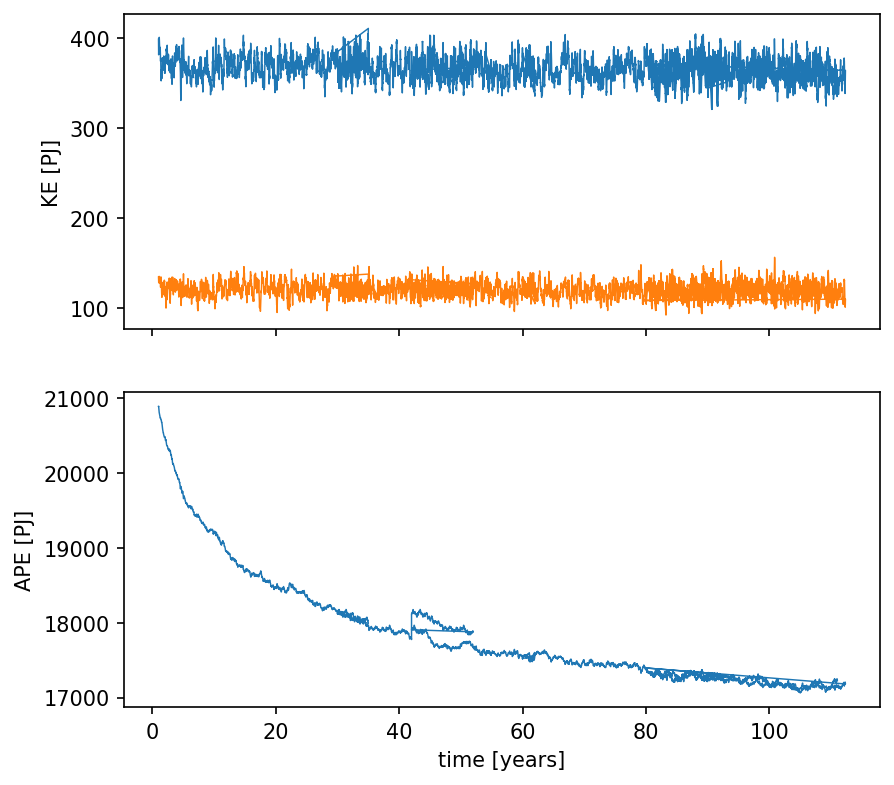

In [121]:
years = stats.Time/360

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6.5, 6))

ax = axs[0]
for zl in range(Nl):
    ax.plot(years, stats.KE.isel(Layer=zl)/1e15, label='layer ' + str(zl+1), lw=.7)
# ax.legend()
ax.set_ylabel('KE [PJ]')

ax = axs[1]
for zi in range(1,Nl):
    ax.plot(years, stats.APE.isel(Interface=zi)/1e15, label='interface ' + str(zi), lw=.7)
# ax.legend()
ax.set_ylabel('APE [PJ]')
ax.set_xlabel('time [years]')

fig.savefig(os.path.join(expdir, 'energy.pdf'), bbox_inches='tight')

# Means

## Velocity

In [197]:
ubar = prog.u.isel(time=time_mean).mean('time').load()
vbar = prog.v.isel(time=time_mean).mean('time').load()
ηbar = prog.e.isel(time=time_mean).mean('time').load()

In [ ]:
1.0229509+

In [200]:
ηbar.mean(('xh', 'yh'))

<xarray.DataArray 'e' (zi: 3)>
array([ 1.0229509e+00, -4.8841129e+02, -5.0000000e+03], dtype=float32)
Coordinates:
  * zi       (zi) float64 1.034e+03 1.036e+03 1.038e+03

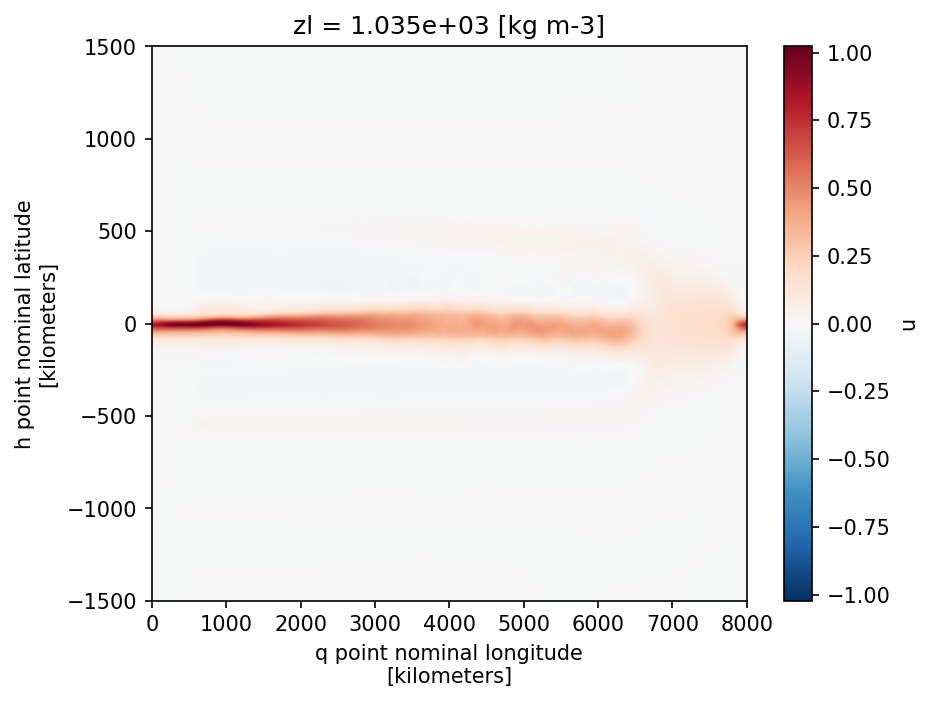

In [20]:
if not is_script:
    ubar.isel(zl=0).plot()

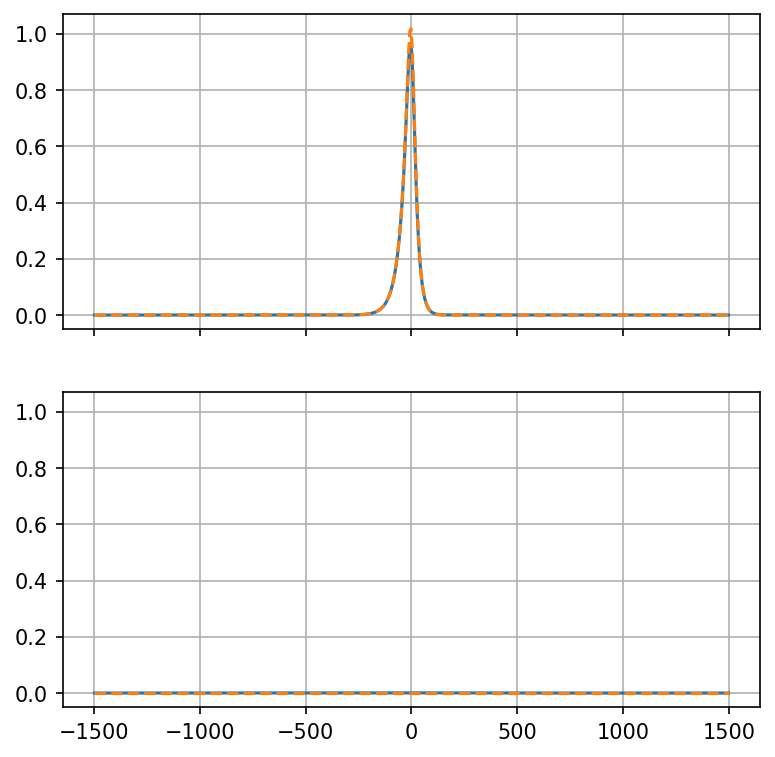

In [21]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 6))

X = 250

for zl in range(2):
    axs[zl].plot(grid.yh, ubar.isel(zl=zl).sel(xq=X, method='nearest'))
    axs[zl].plot(grid.yh, real_ic.u.isel(zl=zl).sel(xq=X, method='nearest'), '--')
    axs[zl].grid()
    
fig.savefig(os.path.join(expdir, 'usponge.pdf'), bbox_inches='tight')

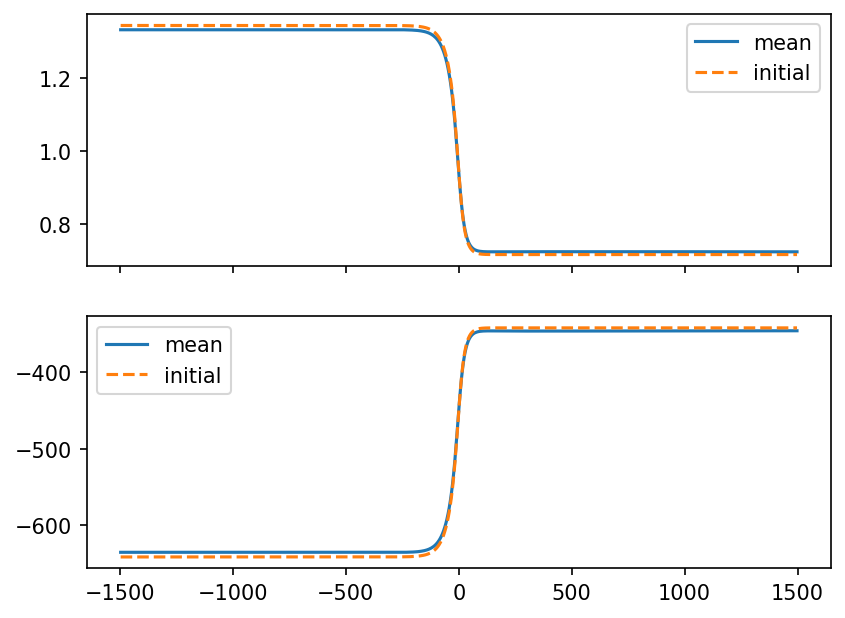

In [22]:
fig, axs = plt.subplots(nrows=2, sharex=True)

for k in range(2):
    ax = axs[k]
    ax.plot(grid.yh, ηbar.isel(zi=k).sel(xh=X, method='nearest'), label='mean')
    ax.plot(grid.yh, real_ic.eta.isel(zi=k).sel(xh=X, method='nearest'), '--', label='initial')
    # ax.set_xlim(-300, 300)
    ax.legend()

fig.savefig(os.path.join(expdir, 'etasponge.pdf'), bbox_inches='tight')

## Streamfunctions

### Barotropic and per layer

In [17]:
U = prog.uh.isel(time=time_mean).mean('time').load()
psi = -1e-6*grid_op.cumsum(U, 'Y', boundary='fill', fill_value=0)
psi = psi - psi.isel(yq=-1).mean('xq')/2

psiB = psi.sum('zl')

In [18]:
recirc_pos_south = psiB.argmax(dim=('xq', 'yq'))
recirc_pos_north = psiB.argmin(dim=('xq', 'yq'))

recirc_x_south = float(psiB.xq.isel(xq=int(recirc_pos_south['xq'])))
recirc_x_north = float(psiB.xq.isel(xq=int(recirc_pos_north['xq'])))

recirc_x = (recirc_x_south + recirc_x_north)/2

recirc_y_south = float(psiB.yq.isel(yq=int(recirc_pos_south['yq'])))
recirc_y_north = float(psiB.yq.isel(yq=int(recirc_pos_north['yq'])))

In [19]:
psiB_S = psiB.isel(yq= 0).mean('xq')
psiB_N = psiB.isel(yq=-1).mean('xq')

recirc_north = float(psiB_N - psiB.min())
recirc_south = float(psiB.max() - psiB_S)

In [235]:
fld[-1]-fld.min()

100.77761

In [237]:
pMin = sp.signal.find_peaks(-fld, prominence=2)[0]
fld[pMin[0]] 

31.38348

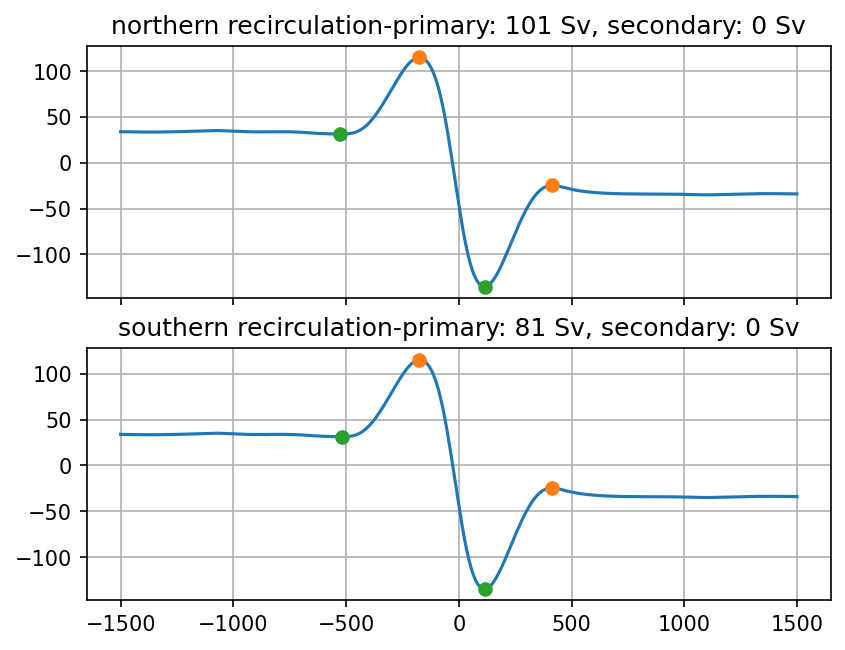

In [238]:
psi_recirc_S = psiB.isel(xq=int(recirc_pos_south['xq'])).values
psi_recirc_N = psiB.isel(xq=int(recirc_pos_north['xq'])).values
y = psiB.yq.values

fig, axs = plt.subplots(nrows=2, sharex=True)

ax = axs[0]
fld = psi_recirc_N
pMax = sp.signal.find_peaks( fld, prominence=2)[0]
pMin = sp.signal.find_peaks(-fld, prominence=2)[0]

# T_north_primary = fld[pMax[-1]] - fld[pMin[-1]]
# T_north_secondary = fld[pMax[-1]] - fld[-1]

T_north_primary = fld[-1]-fld.min()
T_north_secondary = 0
ax.plot(y, fld)
ax.plot(y[pMax], fld[pMax], 'o')
ax.plot(y[pMin], fld[pMin], 'o')
ax.set_title('northern recirculation-primary: {:.0f} Sv, secondary: {:.0f} Sv'.format(T_north_primary, T_north_secondary))
ax.grid()

ax = axs[1]
fld = psi_recirc_S
pMax = sp.signal.find_peaks( fld, prominence=2)[0]
pMin = sp.signal.find_peaks(-fld, prominence=2)[0]

# T_south_primary = fld[pMax[0]] - fld[pMin[0]]
# T_south_secondary = fld[0] - fld[pMin[0]]

T_south_primary = fld.max() - fld[0]
T_south_secondary = 0
ax.plot(y, fld)
ax.plot(y[pMax], fld[pMax], 'o')
ax.plot(y[pMin], fld[pMin], 'o')
ax.set_title('southern recirculation-primary: {:.0f} Sv, secondary: {:.0f} Sv'.format(T_south_primary, T_south_secondary))
ax.grid()

fig.savefig(os.path.join(expdir,'recirc_transport_profile.pdf'), bbox_inches='tight')

In [239]:
def get_psi_vmax_ctick(psiB):
    vmax_psi = float(np.abs(psiB).max())
    if vmax_psi < 50:
        vmax_psi = 10*np.ceil(float(np.abs(psiB).max())/10)
        ctick_interval_psi = 10
    elif vmax_psi < 100:
        vmax_psi = 20*np.ceil(float(np.abs(psiB).max())/20)
        ctick_interval_psi = 20
    else:
        vmax_psi = 40*np.ceil(float(np.abs(psiB).max())/40)
        ctick_interval_psi = 40

        
    return vmax_psi, ctick_interval_psi
        

def plot_streamfunction(figsize=(6.5, 6)):
    fig, axs = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=figsize)

    vmax_psi, ctick_interval_psi = get_psi_vmax_ctick(psiB)
        
    cticks = np.arange(-vmax_psi, vmax_psi+1, ctick_interval_psi)
    levels = np.linspace(-vmax_psi, vmax_psi, 65)

    ax = axs[0]
    cs = ax.contourf(psiB.xq, psiB.yq, psiB, levels=levels, vmin=-vmax_psi, vmax=vmax_psi, cmap='RdBu_r')
    fig.colorbar(cs, ticks=np.arange(-vmax_psi, vmax_psi+1, ctick_interval_psi), label='Sv', pad=0.025)
    ax.contour(psiB.xq, psiB.yq, psiB, levels=np.arange(-vmax_psi, vmax_psi+1, ctick_interval_psi//4), colors='k', linewidths=.25)
    ax.set_ylabel('barotropic')

    ax.set_title('northern recirc: {:.0f} Sv, southern recirc: {:.0f} Sv'.format(T_north_primary, T_south_primary))


    for zl in range(2):
        ax = axs[zl+1]

        cs = ax.contourf(psi.xq, psi.yq, psi.isel(zl=zl), levels=levels, vmin=-vmax_psi, vmax=vmax_psi, cmap='RdBu_r')
        ax.contour(psi.xq, psi.yq, psi.isel(zl=zl), levels=np.arange(-vmax_psi, vmax_psi+1, ctick_interval_psi//4), colors='k', linewidths=.25)

        fig.colorbar(cs, ax=ax, ticks=np.arange(-vmax_psi, vmax_psi+1, ctick_interval_psi), pad=.025, label='Sv')
        ax.set_ylabel('layer {:d}'.format(zl+1))

    for ax in axs:
        ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.01*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
        ax.contour(grid.xh, grid.yh, real_ic.Kh, [.01*float(real_ic.Kh.max())], colors='k', linestyles='-.')
        ax.set_aspect(1)
        ax.axvline(recirc_x, color='k', lw=.5)

    fig.tight_layout()
    
    return fig, axs

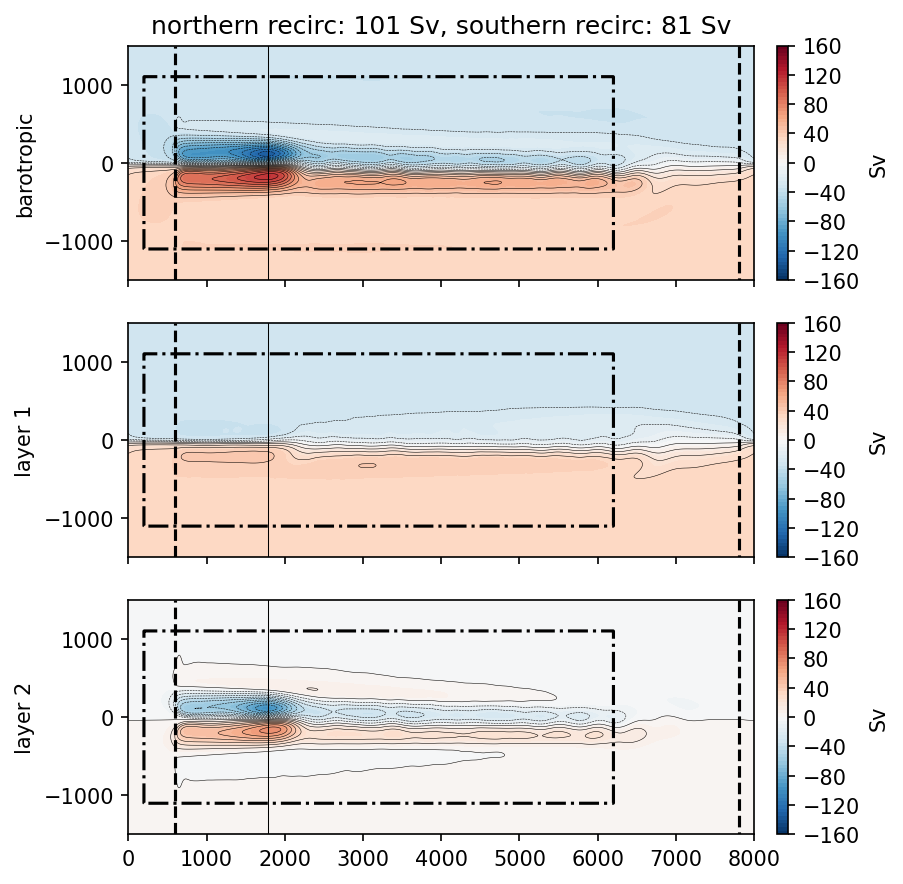

In [240]:
fig, axs = plot_streamfunction()

fig.savefig(os.path.join(expdir,'streamfunction.pdf'), bbox_inches='tight')

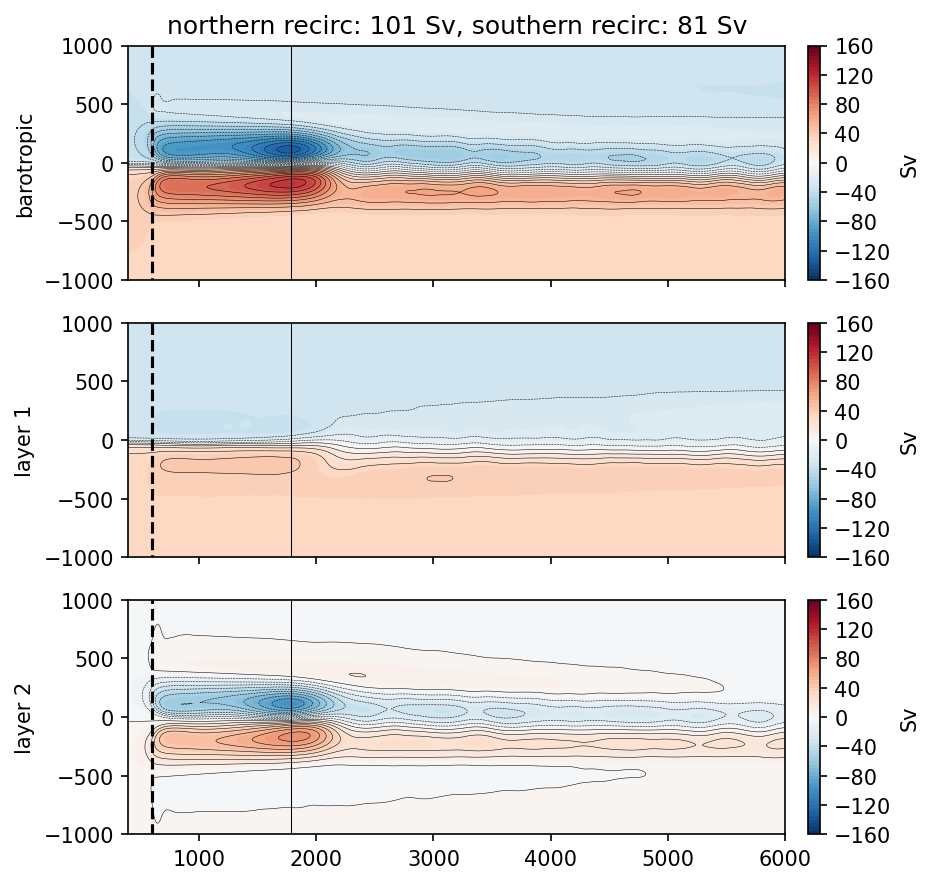

In [241]:
fig, axs = plot_streamfunction()

axs[0].set_ylim(-1000, 1000)
axs[0].set_xlim(400, 6000)

fig.tight_layout()

fig.savefig(os.path.join(expdir,'streamfunction_zoom.pdf'), bbox_inches='tight')

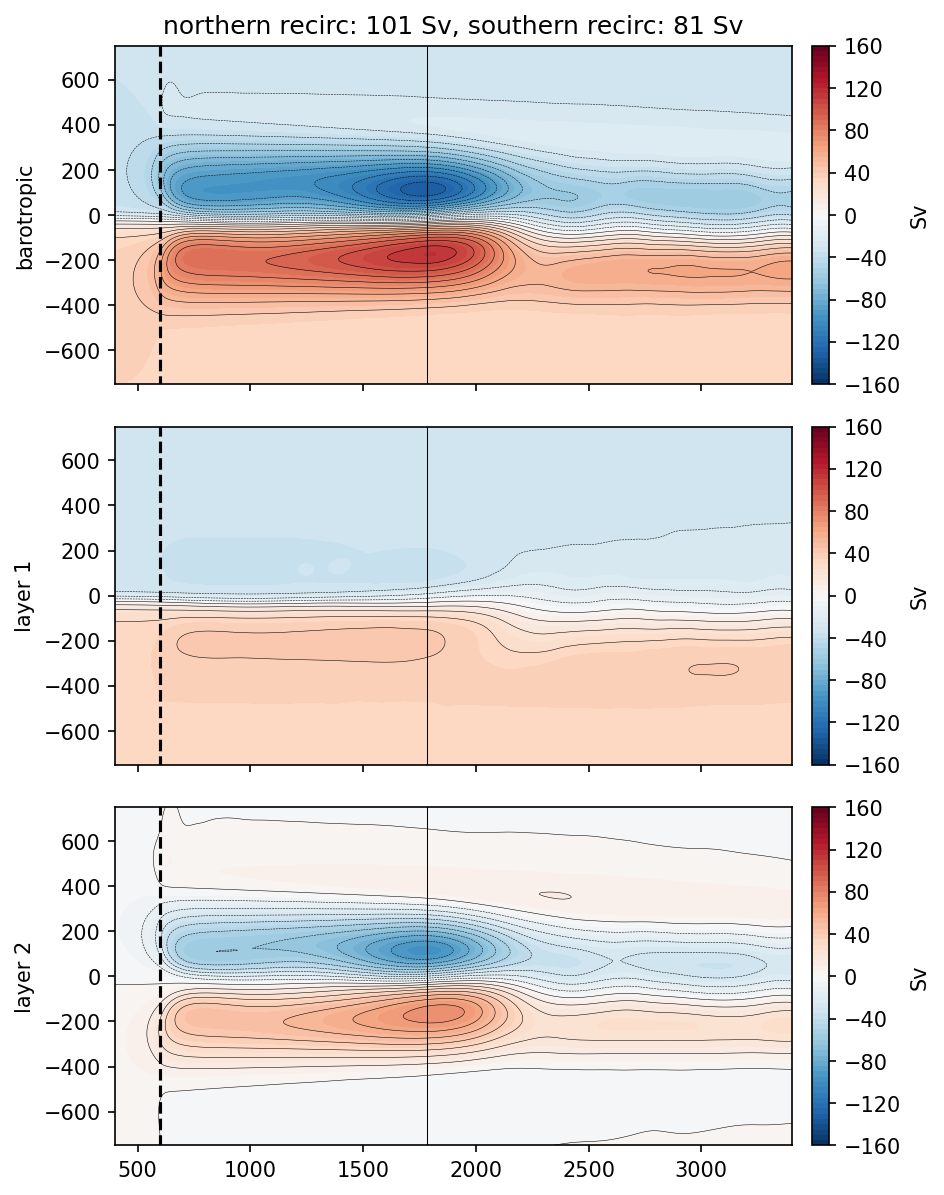

In [242]:
fig, axs = plot_streamfunction(figsize=(6.5, 8))

axs[0].set_ylim(-750, 750)
axs[0].set_xlim(400, 3400)

fig.tight_layout()

fig.savefig(os.path.join(expdir,'streamfunction_zoom_zoom.pdf'), bbox_inches='tight')

- If input flow is 36 Sv, total transport is 73 Sv — a factor of 2
- If input flow is 68 Sv, total transport is 250 Sv — a factor of 3.7

In [232]:
recirc_S = float(psiB.max()-psiB.isel(yq=0).sel(xq=recirc_x, method='nearest'))
recirc_N = float(psiB.isel(yq=-1).sel(xq=recirc_x, method='nearest')-psiB.min())

In [234]:
recirc_S

81.30661010742188

In [233]:
recirc_N

101.08414459228516

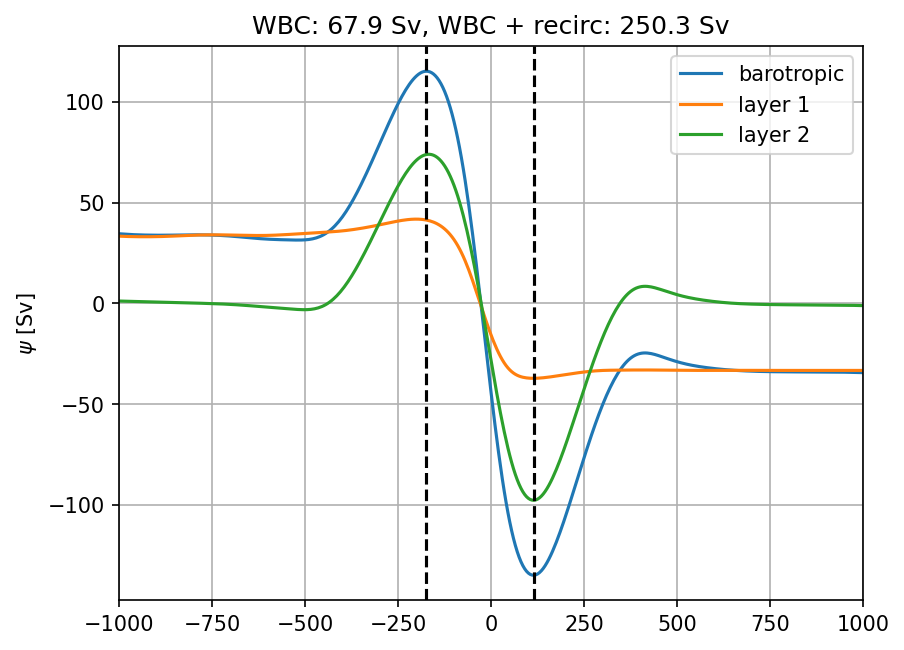

In [229]:
fig, ax = plt.subplots()

wbc = float(psiB.isel(yq=0, xq=0)-psiB.isel(yq=-1, xq=0))
total = psiB.max() - psiB.min()

ax.plot(psiB.yq, psiB.sel(xq=recirc_x, method='nearest'), label='barotropic')
ax.plot(psi.yq, psi.isel(zl=0).sel(xq=recirc_x, method='nearest'), label='layer 1')
ax.plot(psi.yq, psi.isel(zl=1).sel(xq=recirc_x, method='nearest'), label='layer 2')
ax.grid()
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.set_xlim([-1000, 1000])
ax.set_ylabel('$\psi$ [Sv]')
ax.legend()

ax.set_title('WBC: {:.1f} Sv, WBC + recirc: {:.1f} Sv'.format(wbc, total))

fig.savefig(os.path.join(expdir,'streamfunction_recirc_profile.pdf'), bbox_inches='tight')

The recirculation is quite a bit less barotropic if the transport is low.

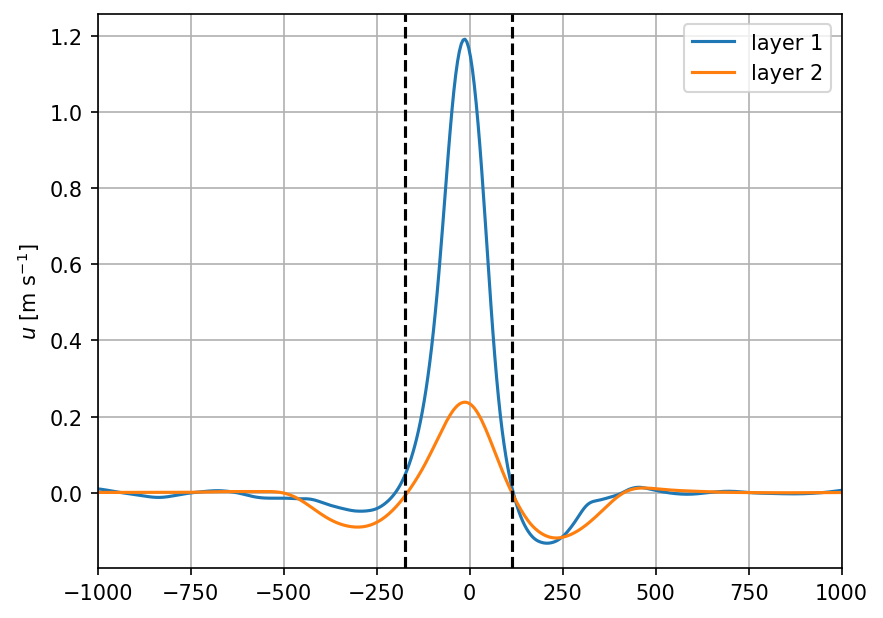

In [132]:
fig, ax = plt.subplots()

ax.plot(grid.yh, ubar.isel(zl=0).sel(xq=recirc_x, method='nearest'), label='layer 1')
ax.plot(grid.yh, ubar.isel(zl=1).sel(xq=recirc_x, method='nearest'), label='layer 2')
ax.set_xlim([-1000, 1000])
ax.grid()
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.legend()
ax.set_ylabel('$u$ [m s$^{-1}$]')

fig.savefig(os.path.join(expdir,'uvel_recirc_profile.pdf'), bbox_inches='tight')

## TWA vorticity

In [204]:
uh = prog.uh.isel(time=time_mean).mean('time').load()
vh = prog.vh.isel(time=time_mean).mean('time').load()
hbar = prog.h.isel(time=time_mean).mean('time').load()

In [205]:
hu = grid_op.interp(hbar, 'X')
hv = grid_op.interp(hbar, 'Y')
hq = grid_op.interp(hv, 'X')

uhat = uh/hu/grid.dyCu
vhat = vh/hv/grid.dxCv

zeta = (grid_op.diff(vhat*grid.dyCv, 'X') - grid_op.diff(uhat*grid.dxCu, 'Y'))/grid.area_q
Pi = (zeta + grid.fq)/hq

This very mysteriously sometimes gives unequally spaced colorbar ticks

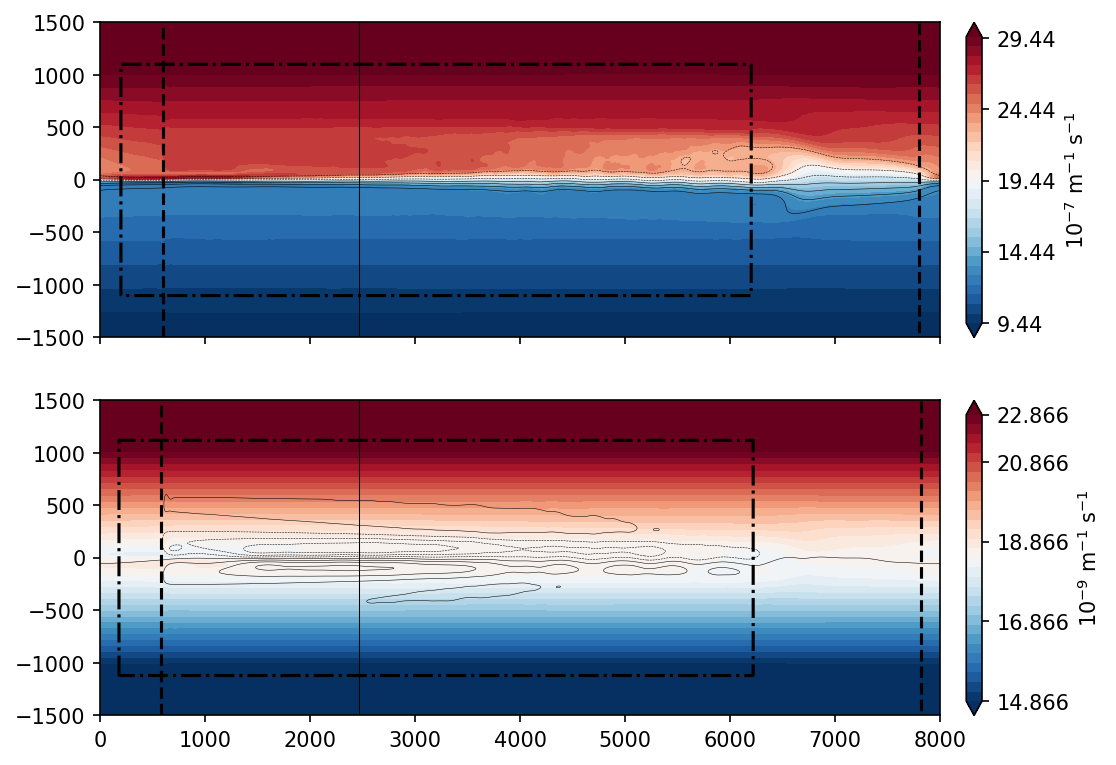

In [103]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 6))

vmax_psi, ctick_interval_psi = get_psi_vmax_ctick(psiB)

ax = axs[0]
fld = 1e8*Pi.isel(zl=0)

vmean = fld.mean()
Δv = np.maximum(fld.sel(yq=slice(-1000, 1000)).max() - vmean, vmean - fld.sel(yq=slice(-1000, 1000)).min())
vmin = vmean - Δv
vmax = vmean + Δv
levels = np.linspace(vmin, vmax, 31)

cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r', extend='both')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 5), label='$10^{-7}$ m$^{-1}$ s$^{-1}$', pad=0.025)
# ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .5), colors='k', linewidths=.25)
ax.contour(fld.xq, fld.yq, psi.isel(zl=0), levels=np.arange(-vmax_psi, vmax_psi, ctick_interval_psi//2), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.01*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.01*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
fld = 1e9*Pi.isel(zl=1)

vmean = float(fld.mean())
Δv = float(np.maximum(fld.sel(yq=slice(-1000, 1000)).max() - vmean, vmean - fld.sel(yq=slice(-1000, 1000)).min()))
vmin = vmean - Δv
vmax = vmean + Δv
levels = np.linspace(vmin, vmax, 31)

cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r', extend='both')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 2), label='$10^{-9}$ m$^{-1}$ s$^{-1}$', pad=0.025)
# ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .25), colors='k', linewidths=.25)
ax.contour(fld.xq, fld.yq, psi.isel(zl=1), levels=np.arange(-vmax_psi, vmax_psi, ctick_interval_psi//2), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.1*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.1*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

fig.savefig(os.path.join(expdir,'PV.pdf'), bbox_inches='tight')

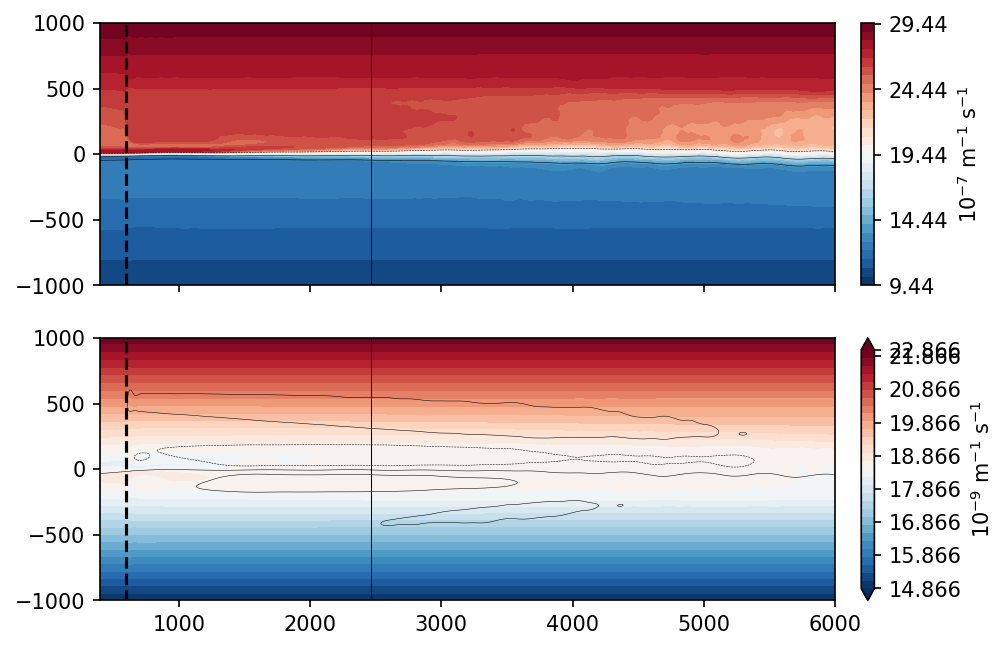

In [107]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 5))

ax = axs[0]

fld = 1e8*Pi.isel(zl=0)

vmean = fld.mean()
Δv = np.maximum(fld.sel(yq=slice(-1000, 1000)).max() - vmean, vmean - fld.sel(yq=slice(-1000, 1000)).min())
vmin = vmean - Δv
vmax = vmean + Δv
levels = np.linspace(vmin, vmax, 31)


cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 5), label='$10^{-7}$ m$^{-1}$ s$^{-1}$', pad=0.025)
# ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .5), colors='k', linewidths=.25)
ax.contour(fld.xq, fld.yq, psi.isel(zl=0), levels=np.arange(-140, 150, 10), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.01*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.01*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
fld = 1e9*Pi.isel(zl=1)
vmean = fld.mean()
Δv = np.maximum(fld.sel(yq=slice(-1000, 1000)).max() - vmean, vmean - fld.sel(yq=slice(-1000, 1000)).min())
vmin = vmean - Δv
vmax = vmean + Δv
levels = np.linspace(vmin, vmax, 31)

cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r', extend='both')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 1), label='$10^{-9}$ m$^{-1}$ s$^{-1}$', pad=0.025)
# ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .25), colors='k', linewidths=.25)
ax.contour(fld.xq, fld.yq, psi.isel(zl=1), levels=np.arange(-140, 150, 10), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.01*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.01*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.set_ylim(-1000, 1000)
ax.set_xlim(400, 6000)
ax.axvline(recirc_x, color='k', lw=.5)

fig.savefig(os.path.join(expdir,'PV_zoom.pdf'), bbox_inches='tight')

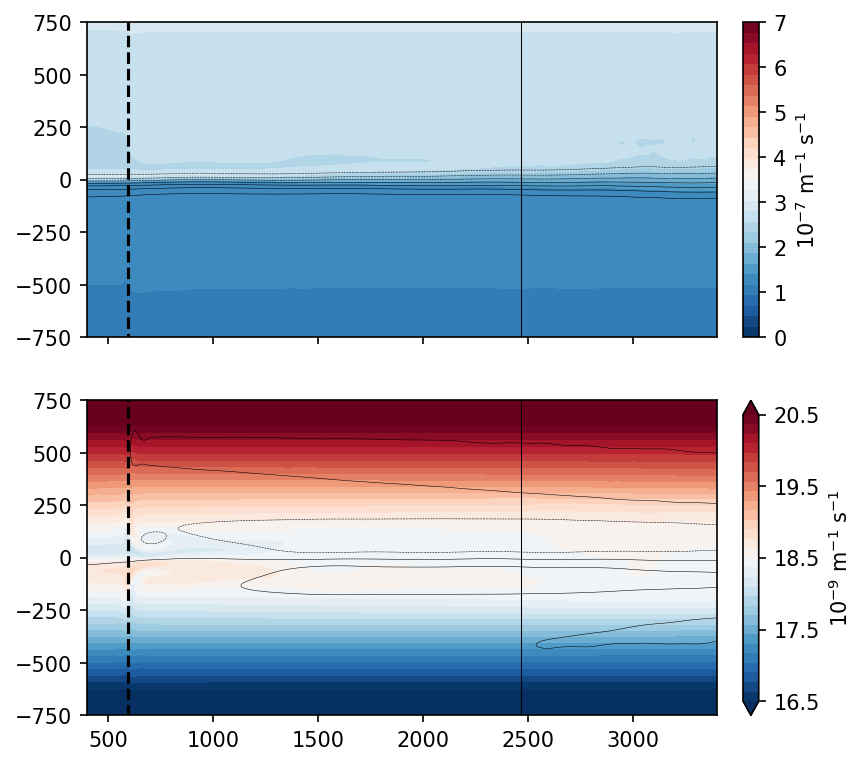

In [52]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 6))

ax = axs[0]

fld = 1e7*Pi.isel(zl=0)

vmin = 0
vmax = 7
levels = np.linspace(vmin, vmax, 31)


cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 1), label='$10^{-7}$ m$^{-1}$ s$^{-1}$', pad=0.025)
# ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .25), colors='k', linewidths=.25)
ax.contour(fld.xq, fld.yq, psi.isel(zl=0), levels=np.arange(-140, 150, 5), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.01*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.01*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
fld = 1e9*Pi.isel(zl=1)

vmin = 18.5 - 2
vmax = 18.5 + 2
levels = np.linspace(vmin, vmax, 31)

cs = ax.contourf(fld.xq, fld.yq, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r', extend='both')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 1), label='$10^{-9}$ m$^{-1}$ s$^{-1}$', pad=0.025)
# ax.contour(fld.xq, fld.yq, fld, levels=np.arange(vmin, vmax+1, .125), colors='k', linewidths=.25)
ax.contour(fld.xq, fld.yq, psi.isel(zl=1), levels=np.arange(-140, 150, 10), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.01*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.01*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.set_ylim(-750, 750)
ax.set_xlim(400, 3400)
ax.axvline(recirc_x, color='k', lw=.5)

fig.savefig(os.path.join(expdir,'PV_zoom_zoom.pdf'), bbox_inches='tight')

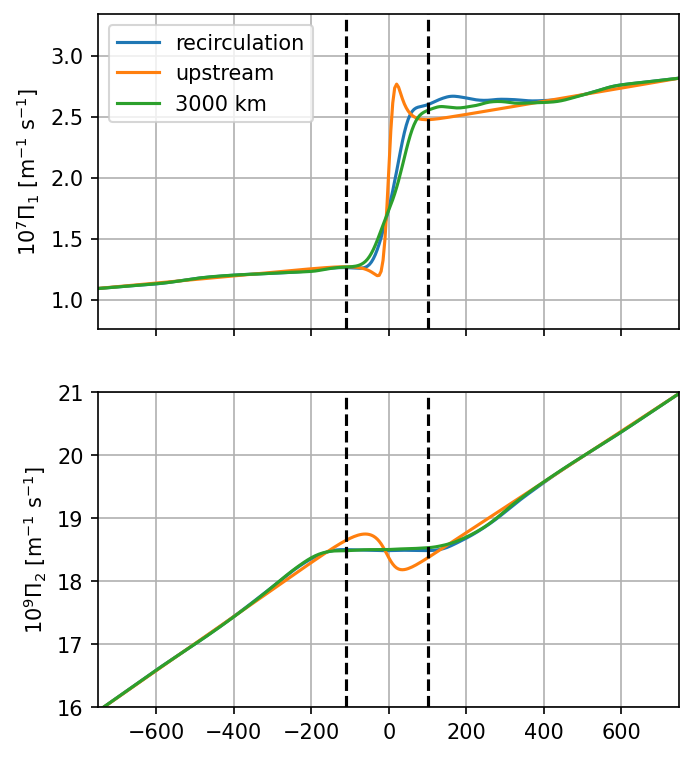

In [53]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(5, 6))

X = 250

ax = axs[0]
fld = 1e7*Pi.isel(zl=0)
ax.plot(fld.yq, fld.sel(xq=recirc_x, method='nearest'), label='recirculation')
ax.plot(fld.yq, fld.sel(xq=X, method='nearest'), label='upstream')
ax.plot(fld.yq, fld.sel(xq=3000, method='nearest'), label='3000 km')
ax.grid()
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.set_ylabel('$10^{7}\Pi_1$ [m$^{-1}$ s$^{-1}$]')
ax.legend()

ax = axs[1]
fld = 1e9*Pi.isel(zl=1)
ax.plot(fld.yq, fld.sel(xq=recirc_x, method='nearest'))
ax.plot(fld.yq, fld.sel(xq=X, method='nearest'))
ax.plot(fld.yq, fld.sel(xq=3000, method='nearest'))
ax.grid()
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.set_ylabel('$10^{9}\Pi_2$ [m$^{-1}$ s$^{-1}$]')
ax.set_ylim(16, 21)

ax.set_xlim([-750, 750])
fig.savefig(os.path.join(expdir,'PV_profile.pdf'), bbox_inches='tight')

## Momentum balance

In [43]:
twa_mean = twa.isel(time=time_mean).mean('time').load()

In [44]:
# zonal
twa_mean['pgf_u'] = twa_mean.h_PFu + twa_mean.h_u_BT_accel
twa_mean['cori_u'] = twa_mean.h_CAu - twa_mean.h_rvxv - twa_mean.h_gKEu
twa_mean['acori_u'] = twa_mean.pgf_u + twa_mean.cori_u
twa_mean.acori_u.attrs['name'] = 'ageostrophic Coriolis/PGF'

twa_mean['adv_u'] = twa_mean.h_rvxv + twa_mean.h_gKEu
twa_mean.adv_u.attrs['name'] = 'advection'

twa_mean.h_diffu.attrs['name'] = 'lateral viscosity'
twa_mean.h_du_dt_visc.attrs['name'] = 'vertical viscosity'
twa_mean.h_du_dt.attrs['name'] = 'tendency'

twa_mean['res_u'] = -twa_mean.acori_u - twa_mean.adv_u - twa_mean.h_diffu - twa_mean.h_du_dt_visc + twa_mean.h_du_dt
twa_mean.res_u.attrs['name'] = 'residual'

# meridional
twa_mean['pgf_v'] = twa_mean.h_PFv + twa_mean.h_v_BT_accel
twa_mean['cori_v'] = twa_mean.h_CAv - twa_mean.h_rvxu - twa_mean.h_gKEv
twa_mean['acori_v'] = twa_mean.pgf_v + twa_mean.cori_v
twa_mean.acori_v.attrs['name'] = 'ageostrophic Coriolis/PGF'

twa_mean['adv_v'] = twa_mean.h_rvxu + twa_mean.h_gKEv
twa_mean.adv_v.attrs['name'] = 'advection'

twa_mean.h_diffv.attrs['name'] = 'lateral viscosity'
twa_mean.h_dv_dt_visc.attrs['name'] = 'vertical viscosity'
twa_mean.h_dv_dt.attrs['name'] = 'tendency'

twa_mean['res_v'] = -twa_mean.acori_v - twa_mean.adv_v - twa_mean.h_diffv - twa_mean.h_dv_dt_visc + twa_mean.h_dv_dt
twa_mean.res_v.attrs['name'] = 'residual'

### Zonal

In [45]:
def plot_mom_zonal(twa_mean, psi, zl, figsize=(9, 5)):
    '''zl < 0 is code for the barotropic budget'''
    
    fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=figsize)

    terms  = [twa_mean.acori_u, twa_mean.adv_u, twa_mean.h_diffu, twa_mean.h_du_dt_visc, -twa_mean.h_du_dt, twa_mean.res_u]
    names = [term.attrs['name'] for term in terms]
    
    if zl < 0:
        terms = [term.sum('zl') for term in terms]
        psi = psi.sum('zl')
    else:
        terms = [term.isel(zl=zl) for term in terms]
        psi = psi.isel(zl=zl)
    
    if zl == len(twa_mean.zl) - 1:
        names[3] = names[3] + ' + drag'

    vmaxs = np.array([float(np.abs(term.sel(xq=slice(400, 6000), yh=slice(-1000, 1000))).max()) for term in terms])
    
    if zl == 0:
        vmaxs[:3] = np.max(vmaxs[:3]) # make the scale for the 3 largest terms the same
    else:
        vmaxs[:4] = np.max(vmaxs[:4]) # make the scale for the 4 largest terms the same
    
    for ax, term, name, vmax in zip(axs.ravel(), terms, names, vmaxs):
        scale = -int(np.floor(np.log10(vmax)))
        fac = 10**scale

        pc = ax.pcolormesh(twa_mean.xq, twa_mean.yh, fac*term, vmin=-fac*vmax, vmax=fac*vmax, cmap='RdBu_r')
        ax.contour(twa_mean.xq, twa_mean.yq, psi, levels=np.arange(-160, 170, 10), colors='k', linewidths=.25)
        fig.colorbar(pc, ax=ax, pad=.025).ax.tick_params(labelsize=8)
        ax.set_title(name + ' ($\\times 10^{{{:d}}}$)'.format(scale))

        ax.set_aspect(1)

    ax.set_xlim(400, 6000)
    ax.set_ylim(-1000, 1000)

    if zl < 0:
        fig.suptitle('barotropic')
    else:
        fig.suptitle('layer {:d}'.format(zl+1))
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.2)
    
    return fig, axs

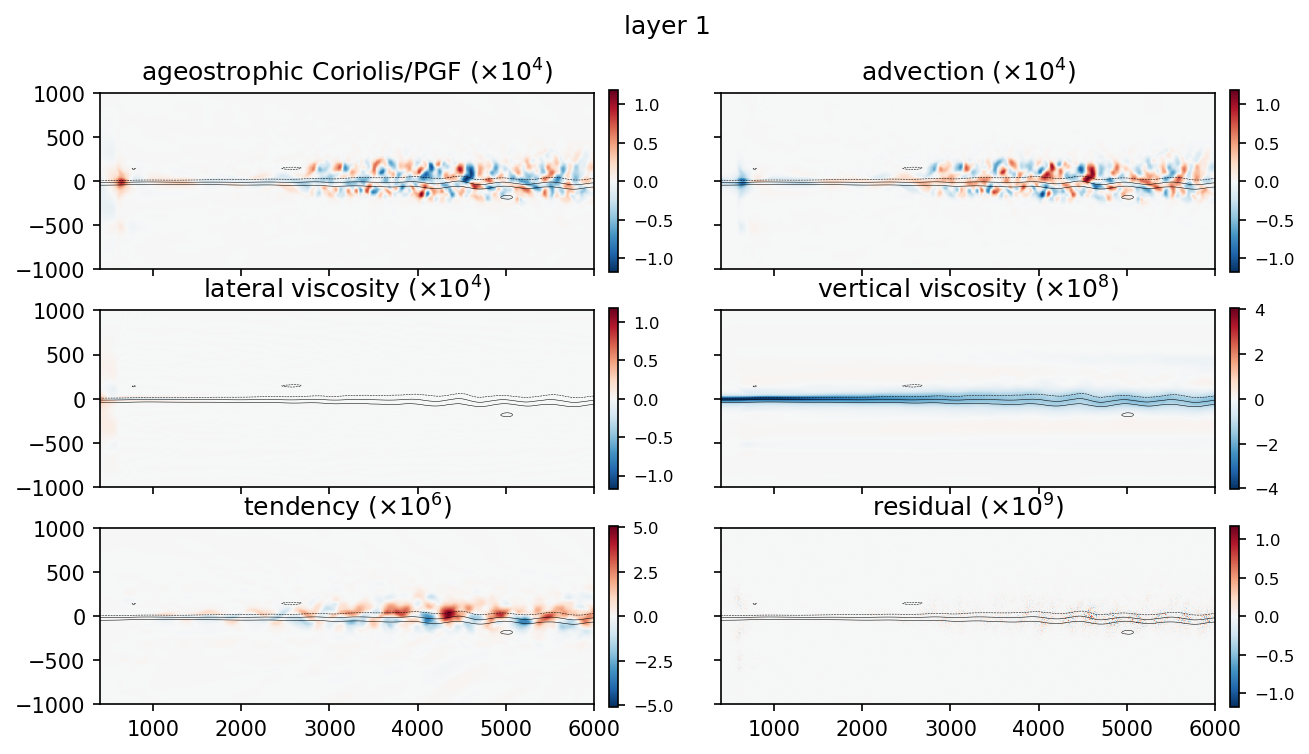

In [46]:
zl = 0
fig, axs = plot_mom_zonal(twa_mean, psi, zl)

fig.savefig(os.path.join(expdir,'momentum_budget_zonal_layer{:d}.png'.format(zl+1)), bbox_inches='tight', dpi=150)

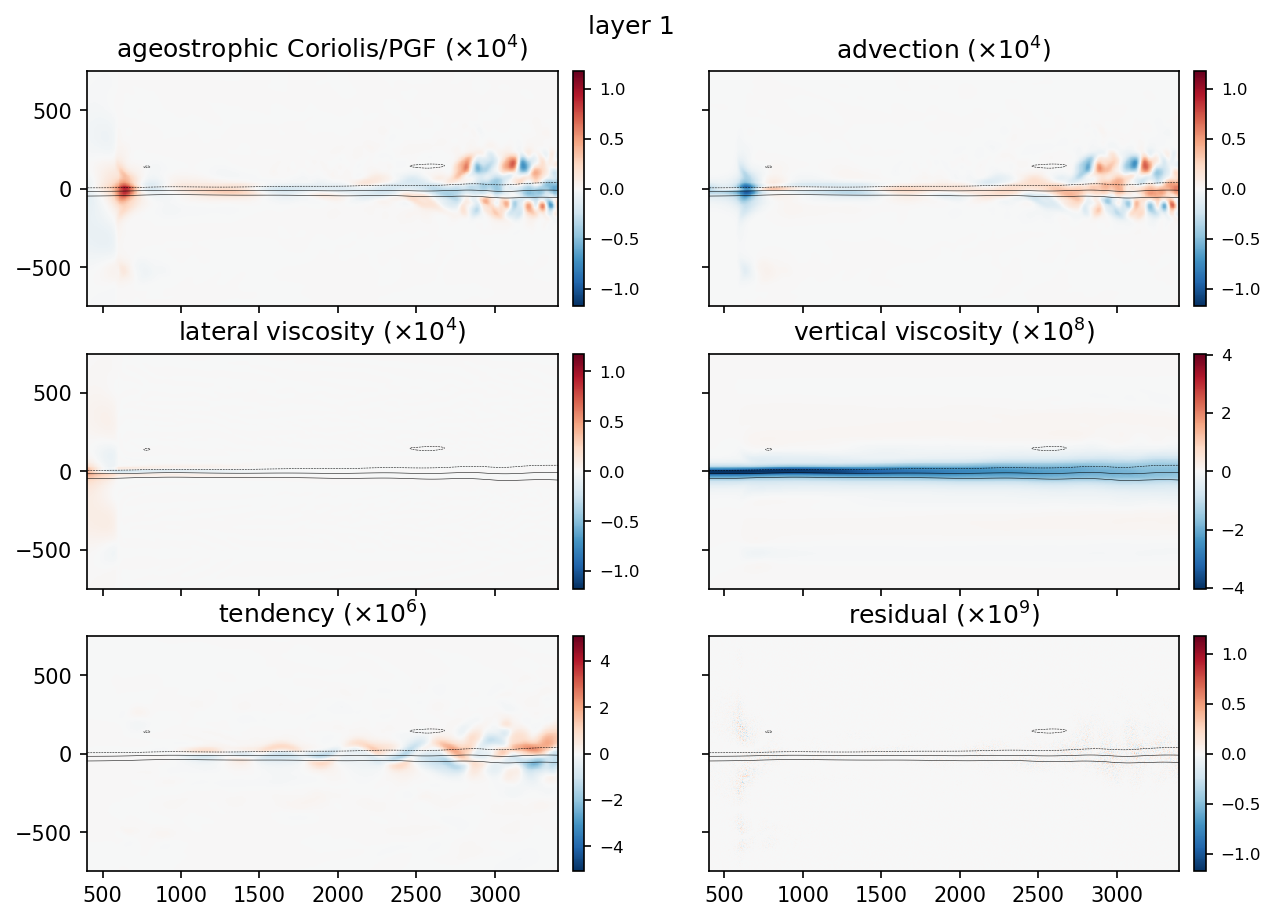

In [47]:
zl = 0
fig, axs = plot_mom_zonal(twa_mean, psi, zl, figsize=(9, 6))

axs[0,0].set_ylim(-750, 750)
axs[0,0].set_xlim(400, 3400)

fig.savefig(os.path.join(expdir,'momentum_budget_zonal_layer{:d}_zoom.png'.format(zl+1)), bbox_inches='tight', dpi=150)

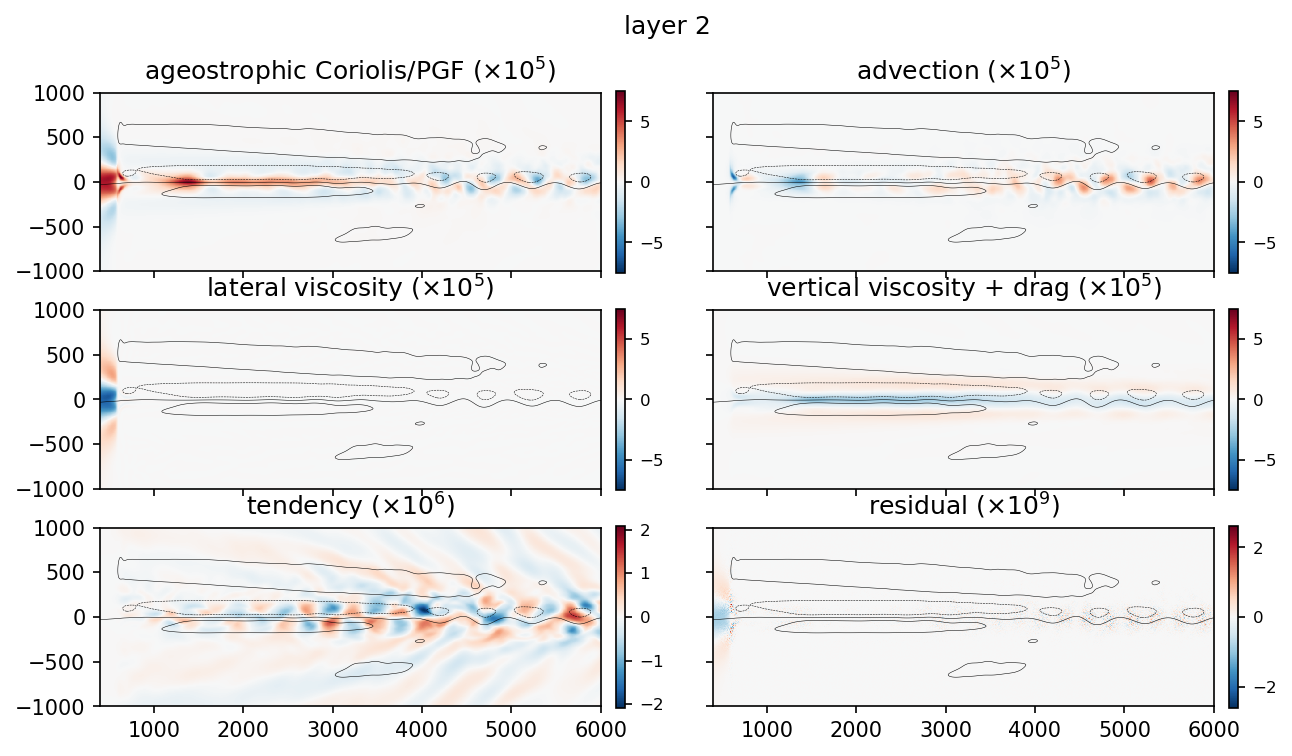

In [48]:
zl = 1
fig, axs = plot_mom_zonal(twa_mean, psi, zl)

fig.savefig(os.path.join(expdir,'momentum_budget_zonal_layer{:d}.png'.format(zl+1)), bbox_inches='tight', dpi=150)

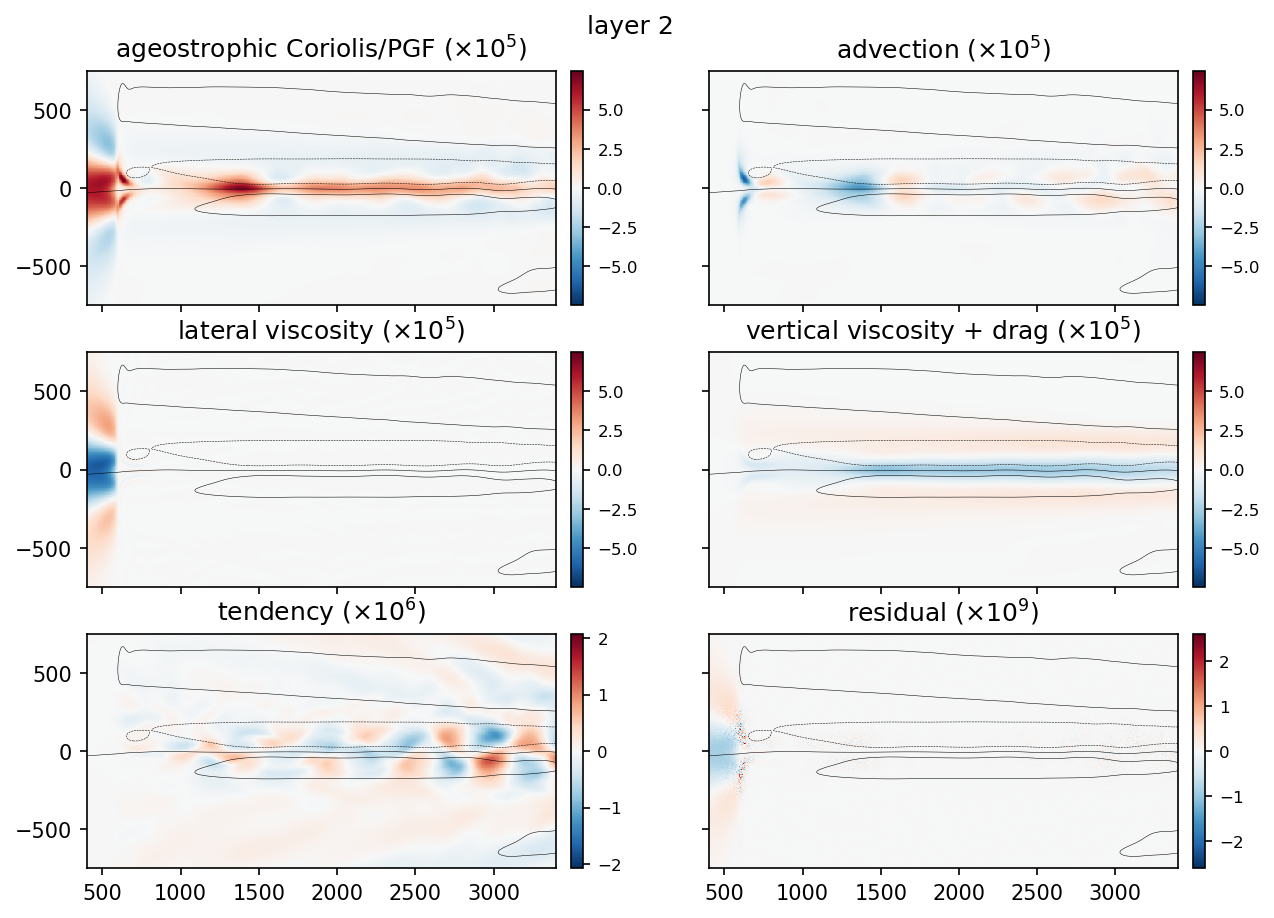

In [49]:
zl = 1
fig, axs = plot_mom_zonal(twa_mean, psi, zl, figsize=(9, 6))

axs[0,0].set_ylim(-750, 750)
axs[0,0].set_xlim(400, 3400)

fig.savefig(os.path.join(expdir,'momentum_budget_zonal_layer{:d}_zoom.png'.format(zl+1)), bbox_inches='tight', dpi=150)

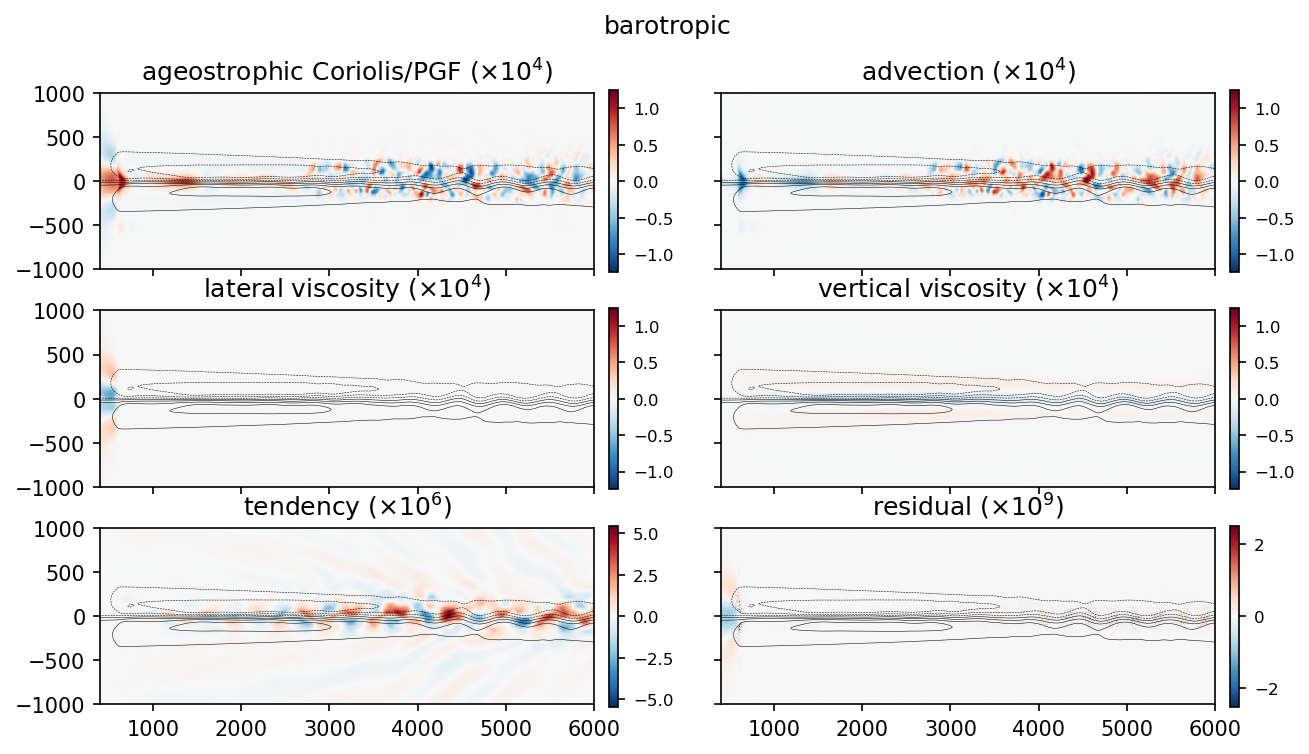

In [50]:
zl = -1
fig, axs = plot_mom_zonal(twa_mean, psi, zl)

fig.savefig(os.path.join(expdir,'momentum_budget_zonal_barotropic.png'.format(zl+1)), bbox_inches='tight', dpi=150)

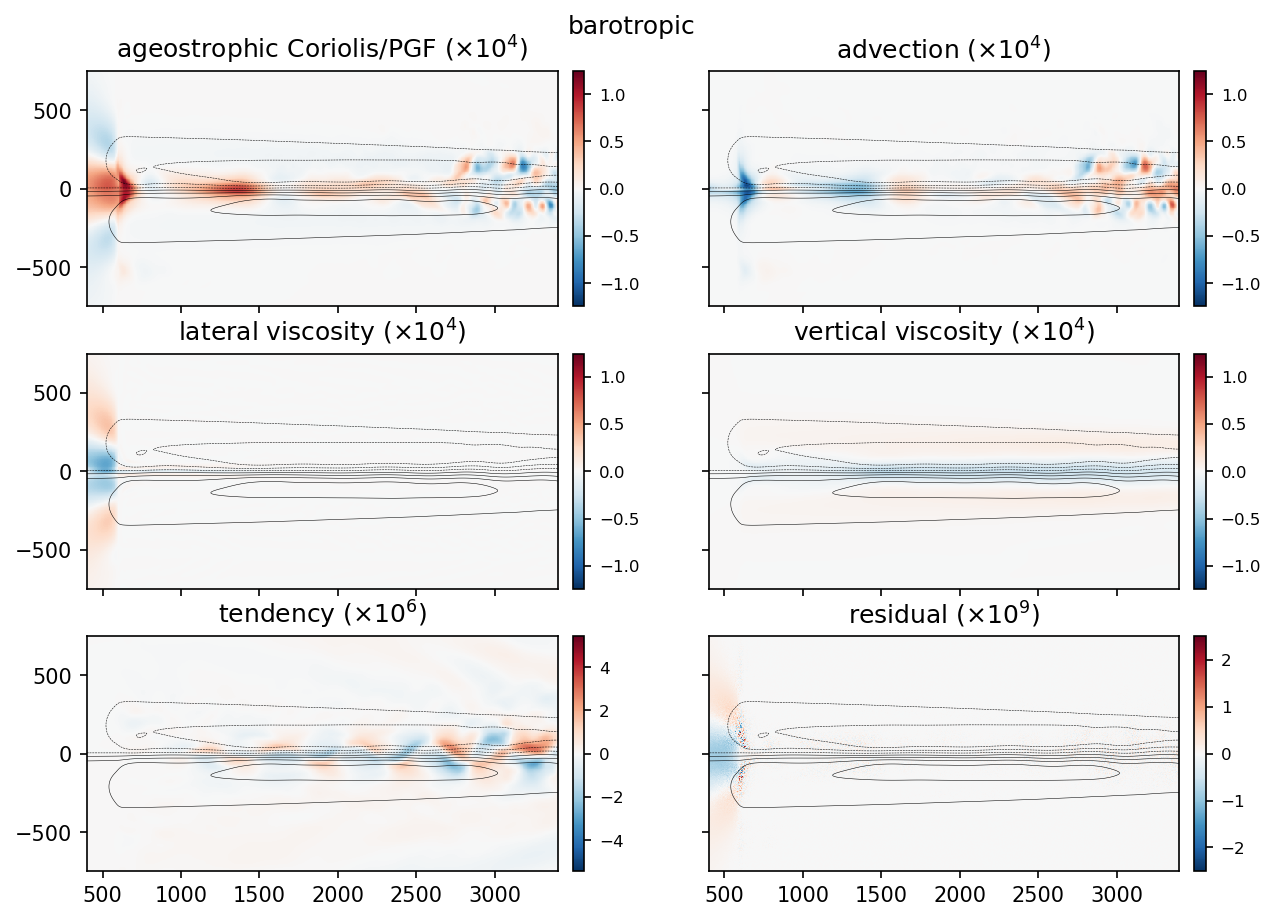

In [51]:
zl = -1
fig, axs = plot_mom_zonal(twa_mean, psi, zl, figsize=(9, 6))

axs[0,0].set_ylim(-750, 750)
axs[0,0].set_xlim(400, 3400)

fig.savefig(os.path.join(expdir,'momentum_budget_zonal_barotropic_zoom.png'.format(zl+1)), bbox_inches='tight', dpi=150)

The vertically averaged viscous tendency should equal the bottom drag divided by $\rho_0$, but it seems that it doesn't. Might have something to do with the fact that vertical viscosity is implicit.

Have posted to the MOM6 forum.

In [52]:
float((-twa_mean.taux_bot/twa_mean.h_du_dt_visc.sum('zl')/ρ0-1).mean())

2.2279098629951477e-05

In [53]:
float((-twa_mean.taux_bot/twa_mean.h_du_dt_visc.sum('zl')).min())

833.7384033203125

In [54]:
vals = (-twa_mean.taux_bot/twa_mean.h_du_dt_visc.sum('zl')/ρ0-1).values.ravel()

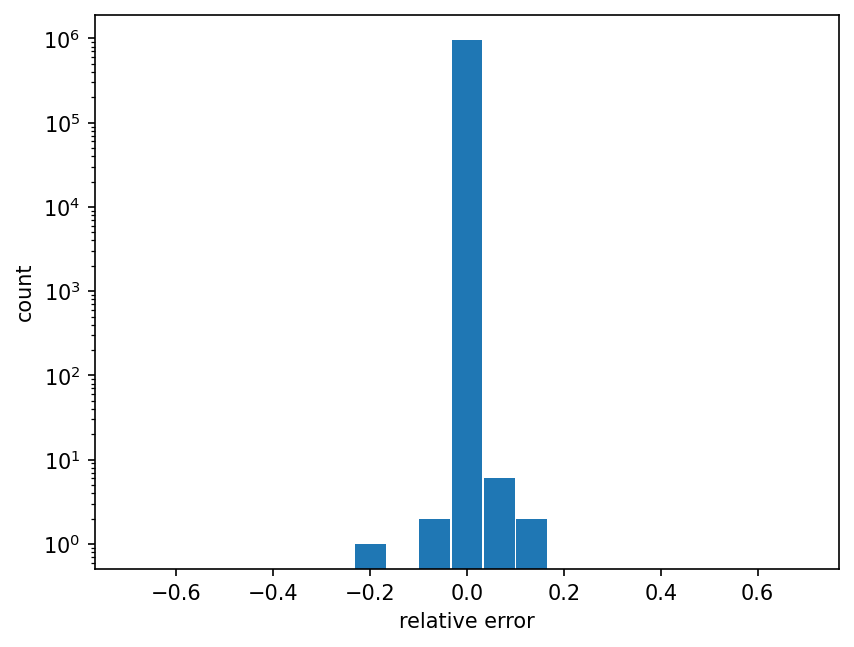

In [55]:
plt.hist(vals, bins=np.linspace(-.7, .7, 22), log=True, rwidth=.95)
plt.xlabel('relative error')
plt.ylabel('count')
plt.savefig('hist.png', bbox_inches='tight')

### Meridional

In [56]:
def plot_mom_merid(twa_mean, psi, zl, figsize=(9, 5)):
    '''zl < 0 is code for the barotropic budget'''
    
    fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=figsize)

    terms  = [twa_mean.acori_v, twa_mean.adv_v, twa_mean.h_diffv, twa_mean.h_dv_dt_visc, -twa_mean.h_dv_dt, twa_mean.res_v]
    names = [term.attrs['name'] for term in terms]
    
    if zl < 0:
        terms = [term.sum('zl') for term in terms]
        psi = psi.sum('zl')
    else:
        terms = [term.isel(zl=zl) for term in terms]
        psi = psi.isel(zl=zl)
    
    if zl == len(twa_mean.zl) - 1:
        names[3] = names[3] + ' + drag'

    vmaxs = np.array([float(np.abs(term.sel(xh=slice(400, 6000), yq=slice(-1000, 1000))).max()) for term in terms])
    
    if zl == 0:
        vmaxs[:2] = np.max(vmaxs[:2]) # make the scale for the 2 largest terms the same
    else:
        vmaxs[:3] = np.max(vmaxs[:3]) # make the scale for the 3 largest terms the same
    
    for ax, term, name, vmax in zip(axs.ravel(), terms, names, vmaxs):
        scale = -int(np.floor(np.log10(vmax)))
        fac = 10**scale

        pc = ax.pcolormesh(twa_mean.xh, twa_mean.yq, fac*term, vmin=-fac*vmax, vmax=fac*vmax, cmap='RdBu_r')
        ax.contour(twa_mean.xq, twa_mean.yq, psi, levels=np.arange(-160, 170, 10), colors='k', linewidths=.25)
        fig.colorbar(pc, ax=ax, pad=.025).ax.tick_params(labelsize=8)
        ax.set_title(name + ' ($\\times 10^{{{:d}}}$)'.format(scale))

        ax.set_aspect(1)

    ax.set_xlim(400, 6000)
    ax.set_ylim(-1000, 1000)

    if zl < 0:
        fig.suptitle('barotropic')
    else:
        fig.suptitle('layer {:d}'.format(zl+1))
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.2)
    
    return fig, axs

The ageostrophic Coriolis force appears to accelerate fluid into the center of the jet, mainly counteracted by advection.

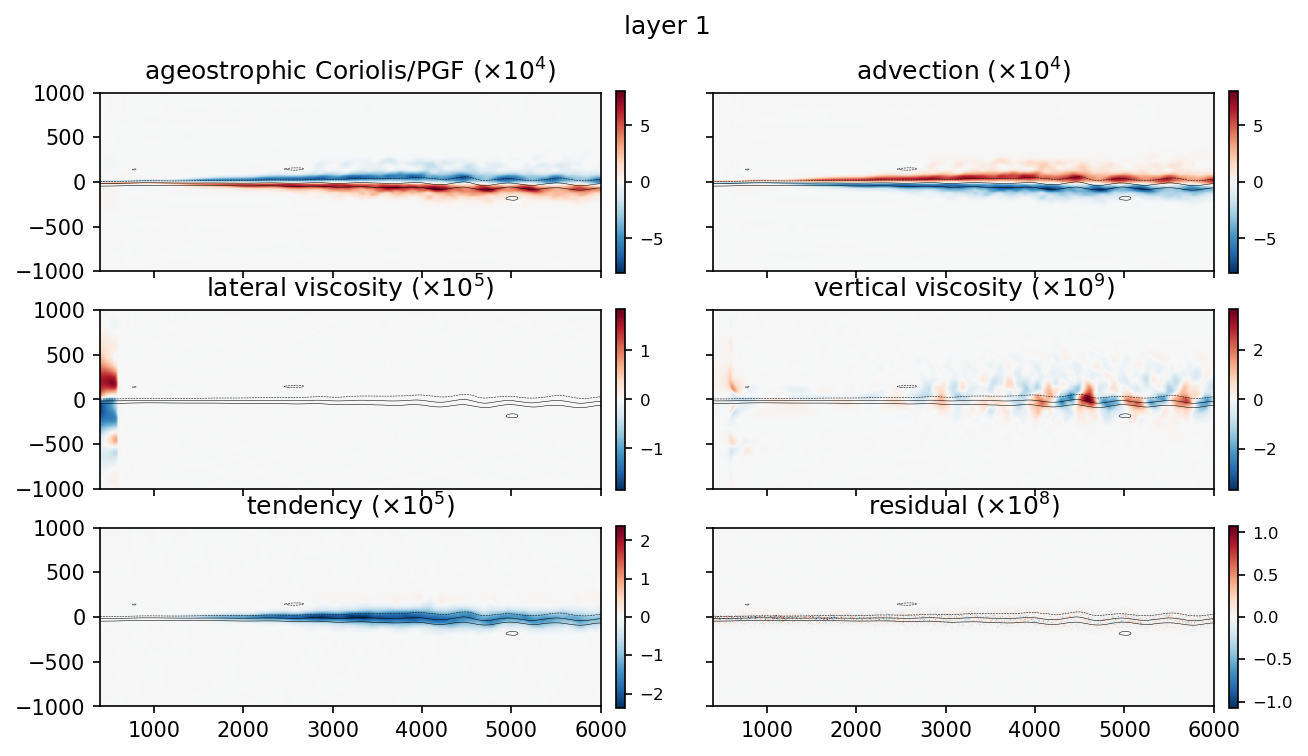

In [57]:
zl = 0
fig, axs = plot_mom_merid(twa_mean, psi, zl)

fig.savefig(os.path.join(expdir,'momentum_budget_meridional_layer{:d}.png'.format(zl+1)), bbox_inches='tight', dpi=150)

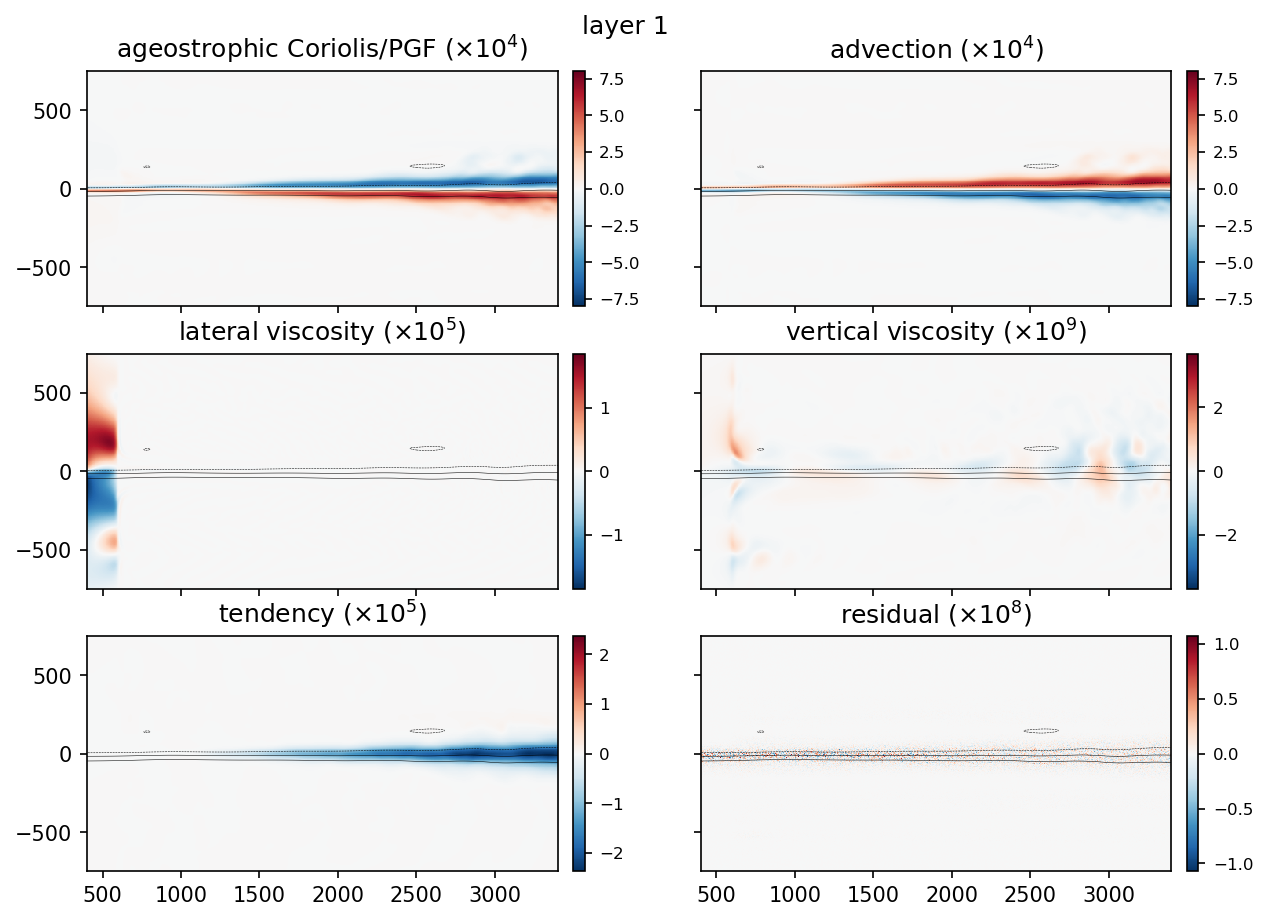

In [58]:
zl = 0
fig, axs = plot_mom_merid(twa_mean, psi, zl, figsize=(9, 6))

axs[0,0].set_ylim(-750, 750)
axs[0,0].set_xlim(400, 3400)

fig.savefig(os.path.join(expdir,'momentum_budget_meridional_layer{:d}_zoom.png'.format(zl+1)), bbox_inches='tight', dpi=150)

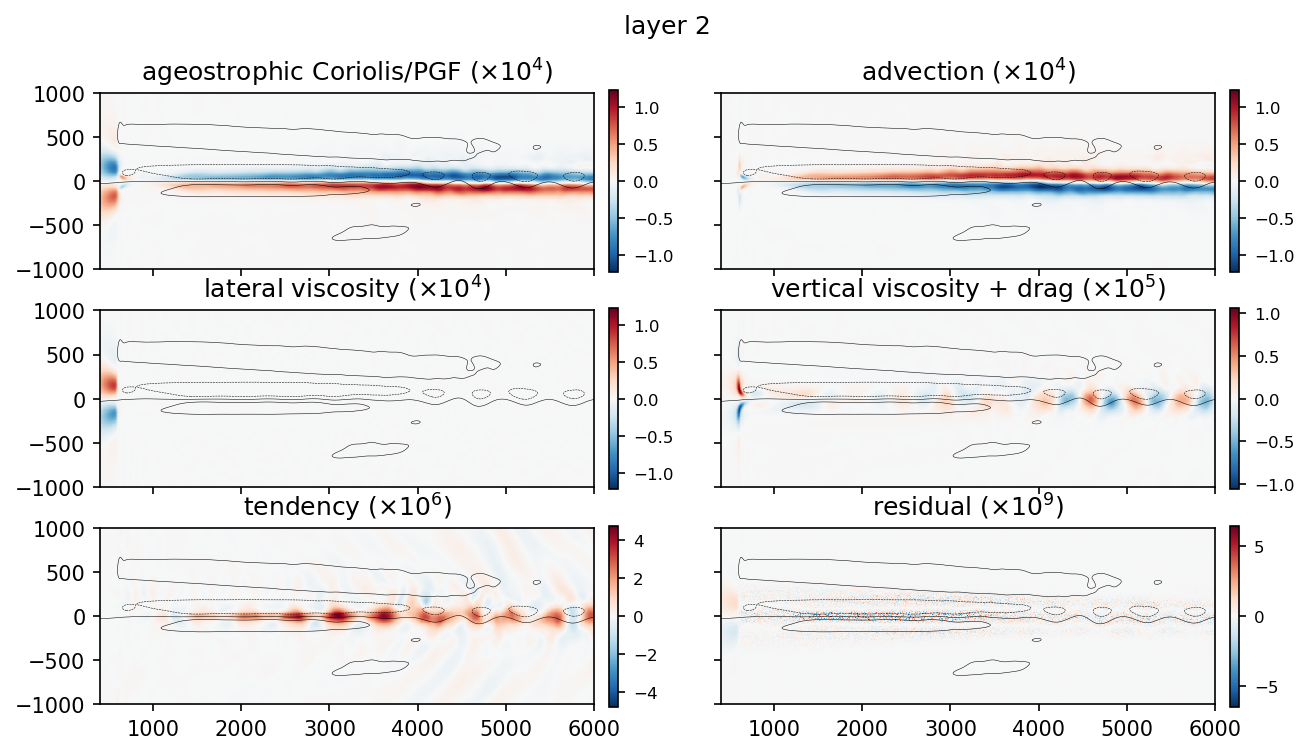

In [59]:
zl = 1
fig, axs = plot_mom_merid(twa_mean, psi, zl)

fig.savefig(os.path.join(expdir,'momentum_budget_meridional_layer{:d}.png'.format(zl+1)), bbox_inches='tight', dpi=150)

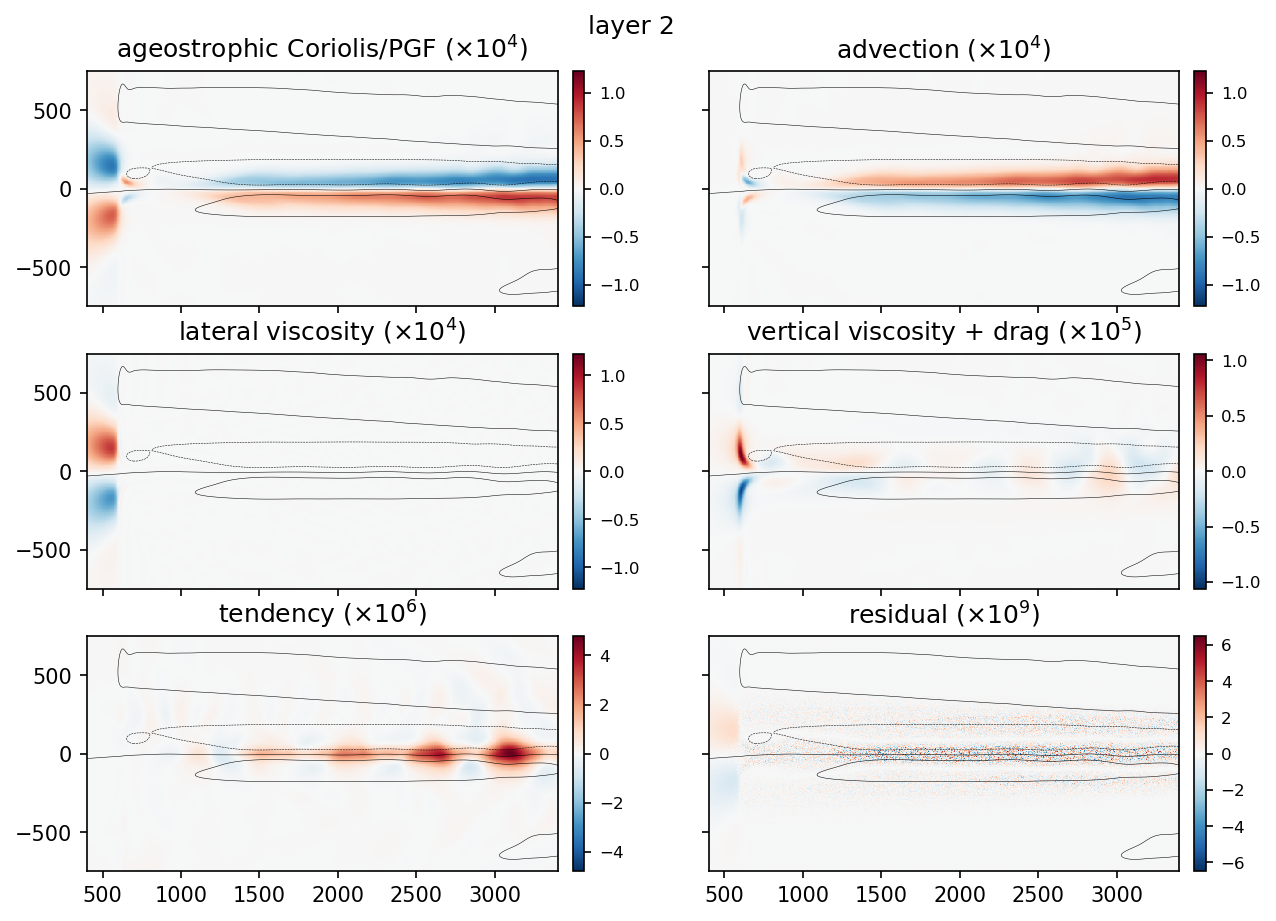

In [60]:
zl = 1
fig, axs = plot_mom_merid(twa_mean, psi, zl, figsize=(9, 6))

axs[0,0].set_ylim(-750, 750)
axs[0,0].set_xlim(400, 3400)

fig.savefig(os.path.join(expdir,'momentum_budget_meridional_layer{:d}_zoom.png'.format(zl+1)), bbox_inches='tight', dpi=150)

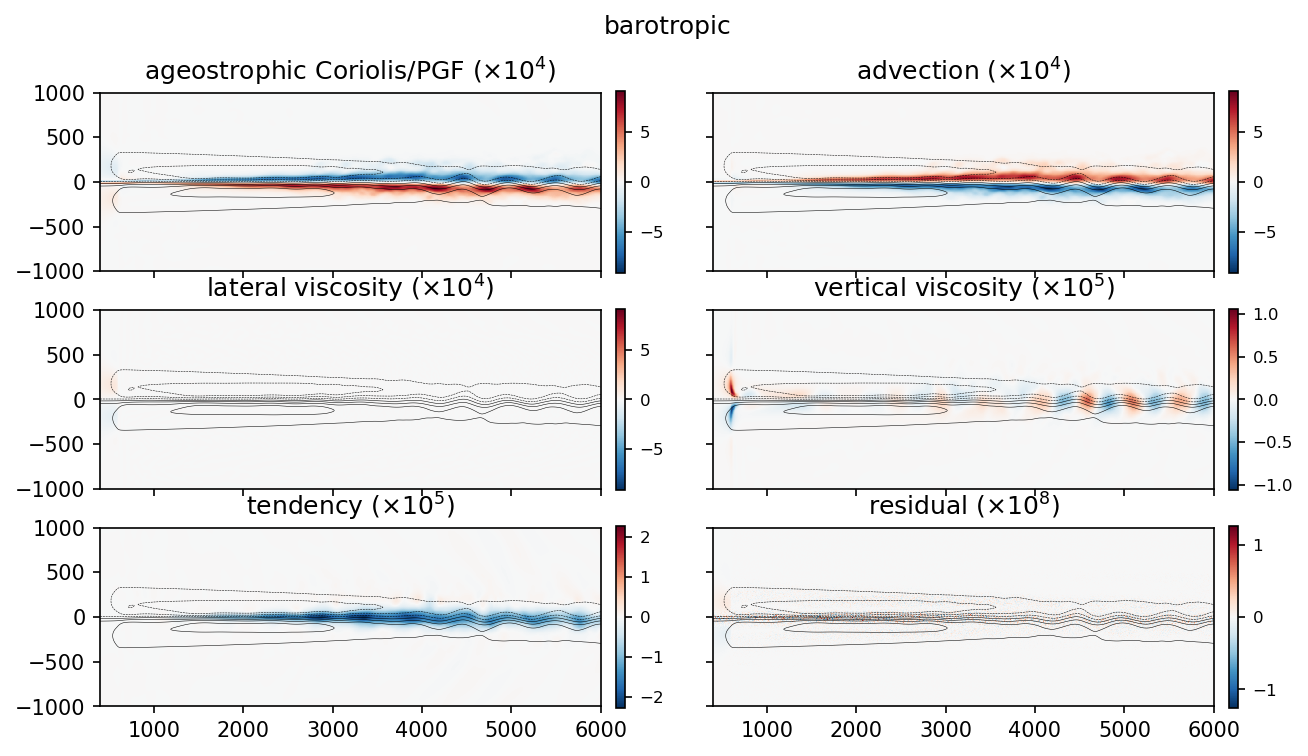

In [61]:
zl = -1
fig, axs = plot_mom_merid(twa_mean, psi, zl)

fig.savefig(os.path.join(expdir,'momentum_budget_meridional_barotropic.png'.format(zl+1)), bbox_inches='tight', dpi=150)

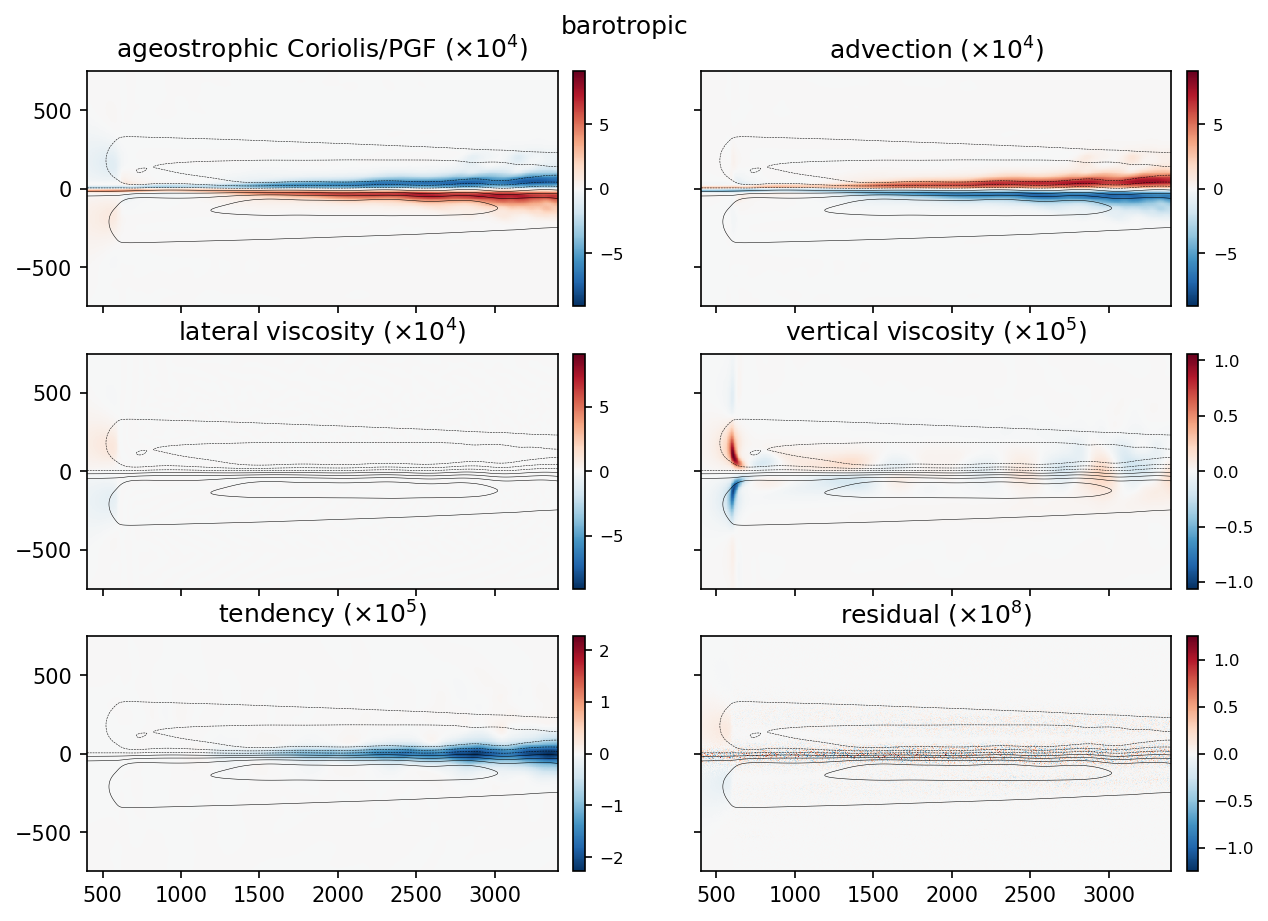

In [62]:
zl = -1
fig, axs = plot_mom_merid(twa_mean, psi, zl, figsize=(9, 6))

axs[0,0].set_ylim(-750, 750)
axs[0,0].set_xlim(400, 3400)

fig.savefig(os.path.join(expdir,'momentum_budget_meridional_barotropic{:d}_zoom.png'.format(zl+1)), bbox_inches='tight', dpi=150)

## Interfaces

In [63]:
ηbar = prog.e.isel(zi=slice(None, 2), time=time_mean).mean('time')

In [64]:
np.abs(ηbar).max(('xh', 'yh')).values

array([  1.3645747, 647.64124  ], dtype=float32)

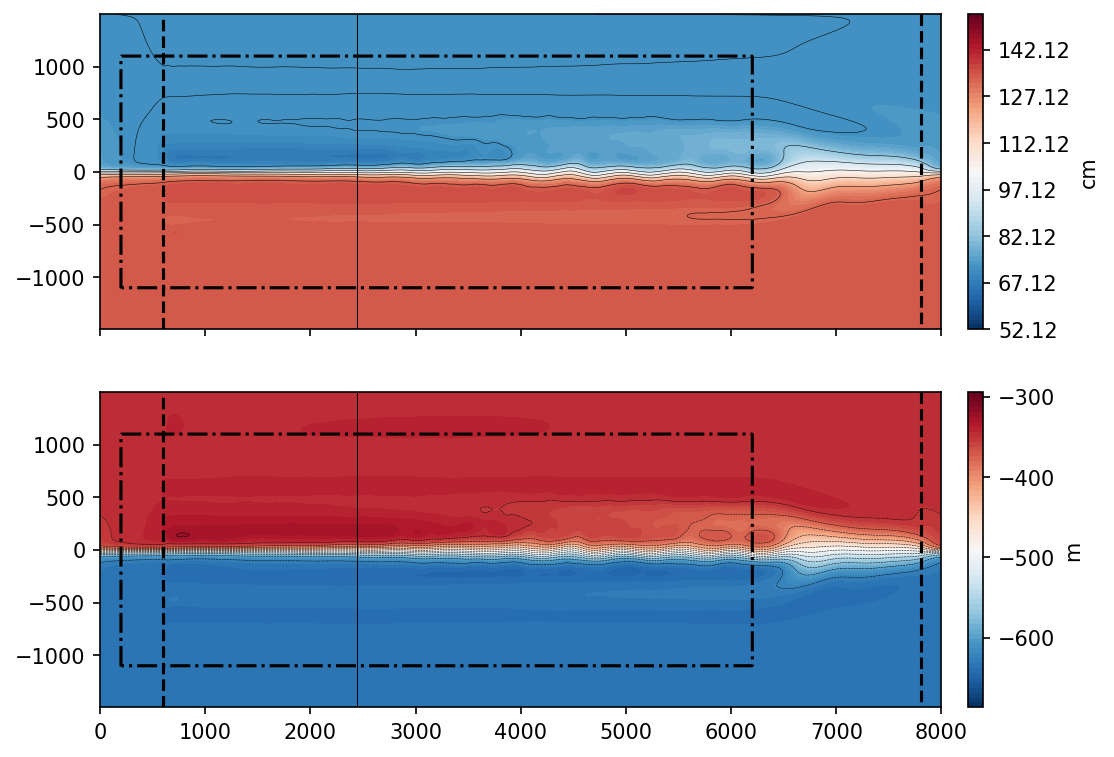

In [65]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 6))

ax = axs[0]
vmin = float(100*ηbar.isel(zi=0, yh=-1).mean().values) - 20
vmax = float(100*ηbar.isel(zi=0, yh= 1).mean().values) + 20
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(ηbar.xh, ηbar.yh, 100*ηbar.isel(zi=0), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 15), label='cm', pad=0.025)
ax.contour(ηbar.xh, ηbar.yh, 100*ηbar.isel(zi=0), levels=np.arange(vmin, vmax+1, 10), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.01*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.01*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
vmin = float(ηbar.isel(zi=1, yh= 0).mean().values) - 50
vmax = float(ηbar.isel(zi=1, yh=-1).mean().values) + 50
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(ηbar.xh, ηbar.yh, ηbar.isel(zi=1), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(-800, -199, 100), label='m', pad=0.025)
ax.contour(ηbar.xh, ηbar.yh, ηbar.isel(zi=1), levels=np.arange(-850, -100+1, 25), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.01*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.01*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

fig.savefig(os.path.join(expdir,'eta.pdf'), bbox_inches='tight')

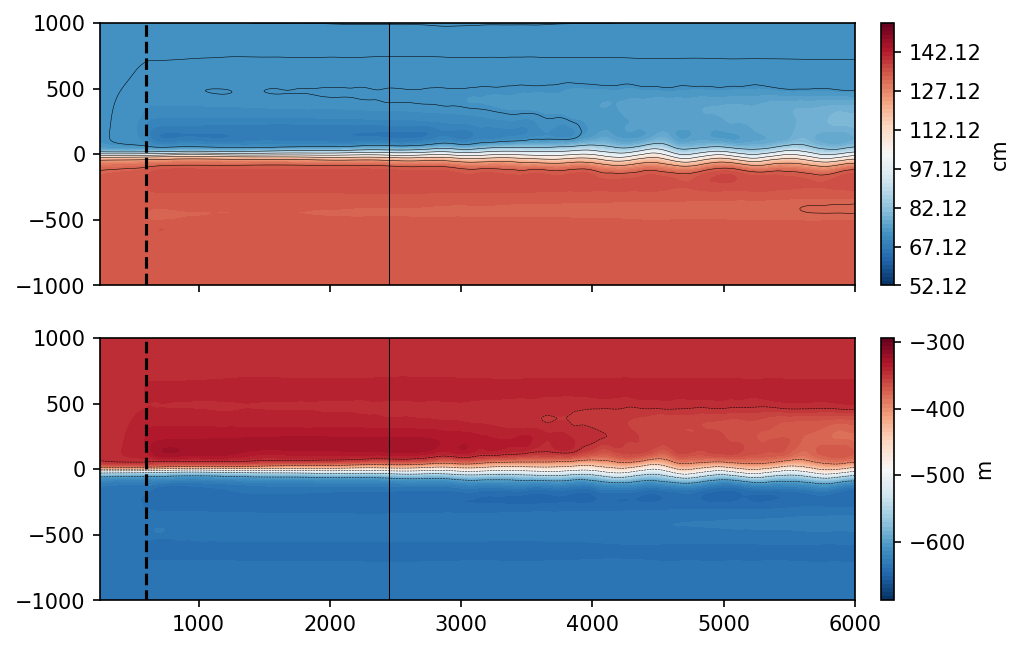

In [66]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 5))

ax = axs[0]
vmin = float(100*ηbar.isel(zi=0, yh=-1).mean().values) - 20
vmax = float(100*ηbar.isel(zi=0, yh= 1).mean().values) + 20
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(ηbar.xh, ηbar.yh, 100*ηbar.isel(zi=0), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 15), label='cm', pad=0.025)
ax.contour(ηbar.xh, ηbar.yh, 100*ηbar.isel(zi=0), levels=np.arange(vmin, vmax+1, 10), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.01*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.01*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.set_ylim(-1000, 1000)
ax.set_xlim(250, 6000)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
vmin = float(ηbar.isel(zi=1, yh= 0).mean().values) - 50
vmax = float(ηbar.isel(zi=1, yh=-1).mean().values) + 50
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(ηbar.xh, ηbar.yh, ηbar.isel(zi=1), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(-800, -199, 100), label='m', pad=0.025)
ax.contour(ηbar.xh, ηbar.yh, ηbar.isel(zi=1), levels=np.arange(-800, -180+1, 50), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.01*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.01*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.set_ylim(-1000, 1000)
ax.set_xlim(250, 6000)
ax.axvline(recirc_x, color='k', lw=.5)

fig.savefig(os.path.join(expdir,'eta_zoom.pdf'), bbox_inches='tight')

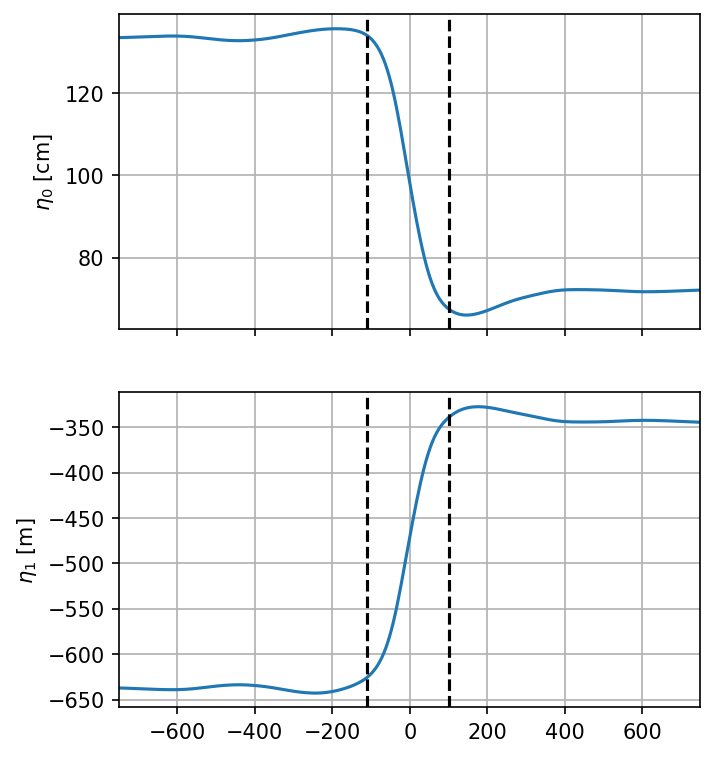

In [67]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(5, 6))

ax = axs[0]
ax.plot(ηbar.yh, 100*ηbar.isel(zi=0).sel(xh=recirc_x, method='nearest'))
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.grid()
ax.set_ylabel('$\eta_0$ [cm]')

ax = axs[1]
ax.plot(ηbar.yh, ηbar.isel(zi=1).sel(xh=recirc_x, method='nearest'))
ax.axvline(recirc_y_south, color='k', ls='--')
ax.axvline(recirc_y_north, color='k', ls='--')
ax.grid()
ax.set_ylabel('$\eta_1$ [m]')

ax.set_xlim([-750, 750])
fig.savefig(os.path.join(expdir,'eta_profile.pdf'), bbox_inches='tight')

## Thicknesses

In [59]:
hbar = prog.h.isel(time=time_mean).mean('time')

In [60]:
np.abs(hbar).max(('xh', 'yh')).values

array([ 788.09033, 4805.5166 ], dtype=float32)

In [61]:
hbar.isel(zl=0, yh=-1).mean().values

array(208.5109, dtype=float32)

In [62]:
hbar.isel(zl=0, yh= 1).mean().values

array(765.99414, dtype=float32)

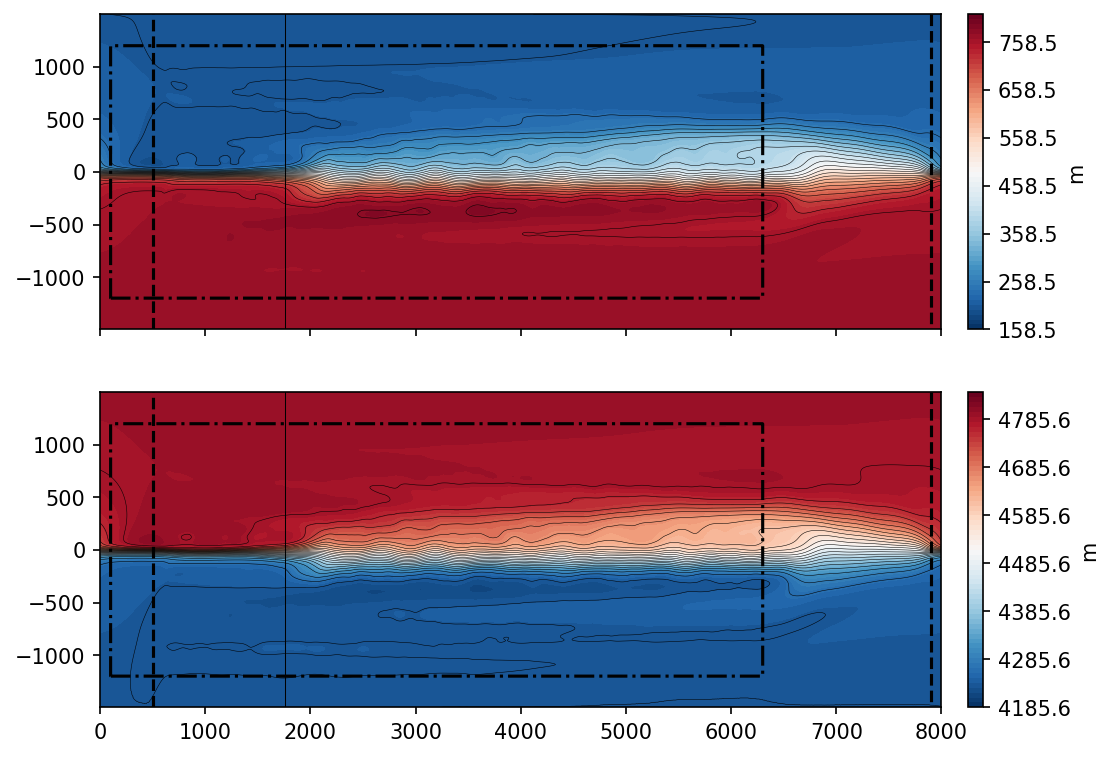

In [63]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 6))

ax = axs[0]
vmin = float(hbar.isel(zl=0, yh=-1).mean().values) - 50
vmax = float(hbar.isel(zl=0, yh= 1).mean().values) + 50
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(hbar.xh, hbar.yh, hbar.isel(zl=0), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 100), label='m', pad=0.025)
ax.contour(hbar.xh, hbar.yh, hbar.isel(zl=0), levels=np.arange(vmin, vmax+1, 25), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
vmax = float(hbar.isel(zl=1, yh=-1).mean().values) + 50
vmin = float(hbar.isel(zl=1, yh= 1).mean().values) - 50
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(hbar.xh, hbar.yh, hbar.isel(zl=1), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 100), label='m', pad=0.025)
ax.contour(hbar.xh, hbar.yh, hbar.isel(zl=1), levels=np.arange(vmin, vmax+1, 25), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

fig.savefig(os.path.join(expdir,'h.pdf'), bbox_inches='tight')

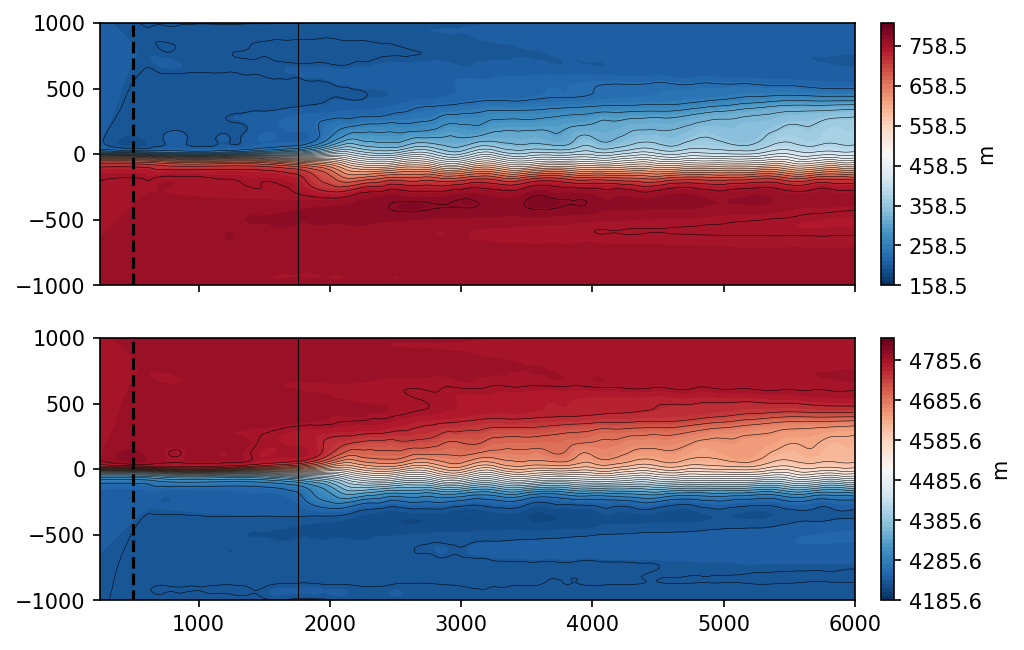

In [64]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 5))

ax = axs[0]
vmin = float(hbar.isel(zl=0, yh=-1).mean().values) - 50
vmax = float(hbar.isel(zl=0, yh= 1).mean().values) + 50
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(hbar.xh, hbar.yh, hbar.isel(zl=0), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 100), label='m', pad=0.025)
ax.contour(hbar.xh, hbar.yh, hbar.isel(zl=0), levels=np.arange(vmin, vmax+1, 25), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
vmax = float(hbar.isel(zl=1, yh=-1).mean().values) + 50
vmin = float(hbar.isel(zl=1, yh= 1).mean().values) - 50
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(hbar.xh, hbar.yh, hbar.isel(zl=1), levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, 100), label='m', pad=0.025)
ax.contour(hbar.xh, hbar.yh, hbar.isel(zl=1), levels=np.arange(vmin, vmax+1, 25), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)
ax.set_ylim(-1000, 1000)
ax.set_xlim(250, 6000)

fig.savefig(os.path.join(expdir,'h_zoom.pdf'), bbox_inches='tight')

## Pressure

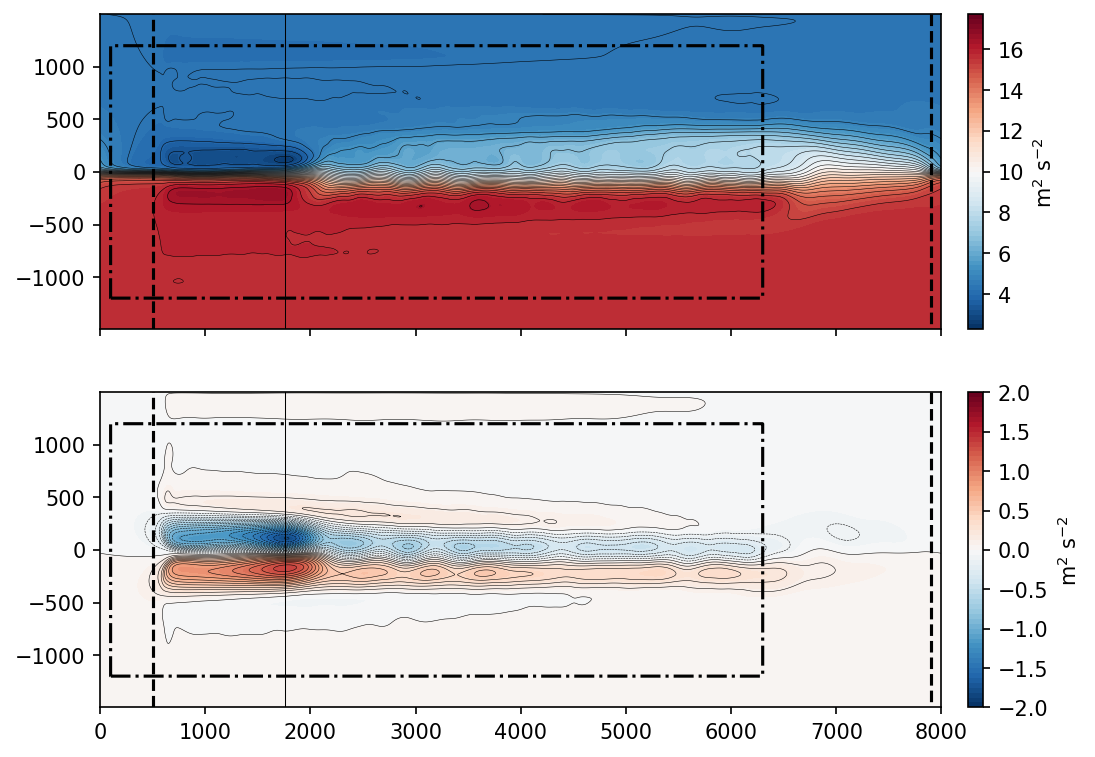

In [70]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 6))

ax = axs[0]

fld = g*ηbar.isel(zi=0)
vmin = float(fld.isel(yh=-1).mean().values) - 2
vmax = float(fld.isel(yh= 1).mean().values) + 2
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(fld.xh, fld.yh, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(2, 20, 2), label='m$^{2}$ s$^{-2}$', pad=0.025)
ax.contour(fld.xh, fld.yh, fld, levels=np.arange(vmin, vmax+1, .5), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
fld = g*ηbar.isel(zi=0) + grid.gprime[1]*ηbar.isel(zi=1)
vmin = -2
vmax = 2
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(fld.xh, fld.yh, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, .5), label='m$^{2}$ s$^{-2}$', pad=0.025)
ax.contour(fld.xh, fld.yh, fld, levels=np.arange(vmin, vmax+.1, .1), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

fig.savefig(os.path.join(expdir,'pressure.pdf'), bbox_inches='tight')

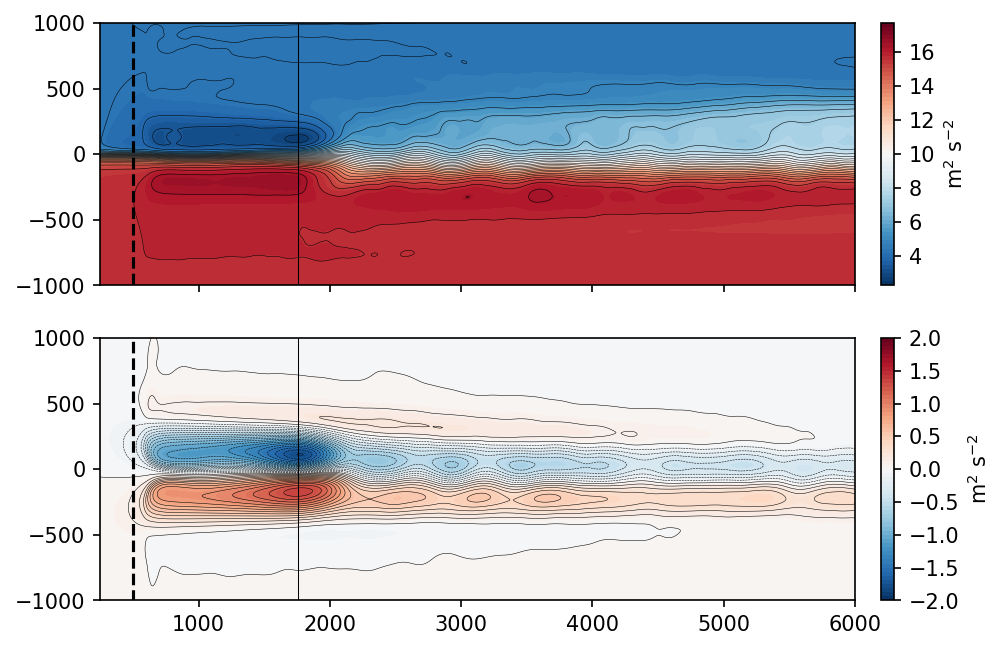

In [71]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(9, 5))

ax = axs[0]

fld = g*ηbar.isel(zi=0)
vmin = float(fld.isel(yh=-1).mean().values) - 2
vmax = float(fld.isel(yh= 1).mean().values) + 2
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(fld.xh, fld.yh, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(2, 20, 2), label='m$^{2}$ s$^{-2}$', pad=0.025)
ax.contour(fld.xh, fld.yh, fld, levels=np.arange(vmin, vmax+1, .5), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)

ax = axs[1]
fld = g*ηbar.isel(zi=0) + grid.gprime[1]*ηbar.isel(zi=1)
vmin = -2
vmax = 2
levels = np.linspace(vmin, vmax, 65)

cs = ax.contourf(fld.xh, fld.yh, fld, levels=levels, vmin=vmin, vmax=vmax, cmap='RdBu_r')
fig.colorbar(cs, ax=ax, ticks=np.arange(vmin, vmax+1, .5), label='m$^{2}$ s$^{-2}$', pad=0.025)
ax.contour(fld.xh, fld.yh, fld, levels=np.arange(vmin, vmax+.1, .1), colors='k', linewidths=.25)
ax.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.5*float(real_ic.Idamp_u.max())], colors='k', linestyles='--')
ax.contour(grid.xh, grid.yh, real_ic.Kh, [.5*float(real_ic.Kh.max())], colors='k', linestyles='-.')
ax.set_aspect(1)
ax.axvline(recirc_x, color='k', lw=.5)
ax.set_ylim(-1000, 1000)
ax.set_xlim(250, 6000)

fig.savefig(os.path.join(expdir,'pressure_zoom.pdf'), bbox_inches='tight')

## Stuff for proposal

### Streamfunction/Vorticity

In [210]:
time=-1

zeta = 1e5*grid_op.interp(
    grid_op.interp(
        ((grid_op.diff(snap.v.isel(time=time).fillna(0)*grid.dyCv, 'X') 
          - grid_op.diff(snap.u.isel(time=time).fillna(0)*grid.dxCu, 'Y'))/grid.area_q), 
        'X'),
    'Y').isel(zl=0)
vms = float(np.abs(zeta).max(dim=('yh', 'xh')))
vms

10.376520156860352

In [28]:
h = (snap.e.isel(zi=0).isel(time=time).drop('zi') - snap.e.isel(zi=1).isel(time=time).drop('zi'))

In [224]:
from scipy.special import erfc
from scipy.optimize import root_scalar, minimize_scalar

def uprime(y, l, δ):
    if δ == 1:
        return 0.25*np.exp((l/4)**2 + y/2)*erfc(l/4 + y/l) - np.exp(-y**2/l**2)/(l*np.sqrt(π))
    else:
        return 0.5*(np.exp((l/(2*(1+δ)))**2 + y/(1+δ))*erfc(l/(2*(1+δ)) + y/l)/(1+δ)
                  - np.exp((l/(2*(1-δ)))**2 - y/(1-δ))*erfc(l/(2*(1-δ)) - y/l)/(1-δ))

def upprime(y, l, δ):
    if δ == 1:
        return 0.125*np.exp((l/4)**2 + y/2)*erfc(l/4 + y/l) + (4*y-l**2)*np.exp(-y**2/l**2)/(2*l**3*np.sqrt(π))
    else:
        return 0.5*((1-δ)*np.exp((l/(2*(1+δ)))**2 + y/(1+δ))*erfc(l/(2*(1+δ)) + y/l)/(1+δ)
                  + (1+δ)*np.exp((l/(2*(1-δ)))**2 - y/(1-δ))*erfc(l/(2*(1-δ)) - y/l)/(1-δ)
                  - 4*np.exp(-y**2/l**2)/(l*np.sqrt(π)))/(1-δ**2)
    
def ufunc(y, l, δ):
    if δ == 1:
        return 0.5*np.exp((l/4)**2 + y/2)*erfc(l/4 + y/l)
    else:
        return 0.5*(np.exp((l/(2*(1+δ)))**2 + y/(1+δ))*erfc(l/(2*(1+δ)) + y/l)
                  + np.exp((l/(2*(1-δ)))**2 - y/(1-δ))*erfc(l/(2*(1-δ)) - y/l))
    
def u1(y, l, δ):
    if l > 0:
        # find the maximum velocity
        res = minimize_scalar(lambda y: -ufunc(y, l, δ), bracket=(-1, 0), method='golden')
        if not res.success:
            raise RuntimeError("Couldn't find function maximum")
        
        y0 = res.x
        umax = -res.fun
        
        # find the 
        
        return ufunc(y+y0, l, δ)/umax
    else:
        if δ == 1:
            return np.where(y <= 0, np.exp( y/2), 0)
        else:
            return np.where(y <= 0, np.exp( y/(1+δ)), np.exp(-y/(1-δ)))



In [207]:
def plot_jet(ax):
    fig = ax.get_figure()
    ves = 2e-2
    cmap = mpl.cm.RdBu_r
    xlim = (0, Lx)
    ylim = (-Ly/2, Ly/2)
    vmin = -vms/2
    vmax =  vms/2
    norm = mpl.colors.Normalize(vmin, vmax)

    pc = ax2.pcolormesh(zeta.xh, zeta.yh, zeta, vmin=vmin, vmax=vmax, cmap=cmap)
        # ax.set_title('$\eta_' + str(n) + '$')
    ax2.set_aspect(1)

    intensity = pw.plt.hillshade(35, 50, h, vertical_exageration=ves)
    rgb = pw.plt.blend_shade(cmap(norm(zeta)), intensity, mid_intensity=.75, min_brightness=.3, max_brightness=.9)
    im = ax2.imshow(np.nan_to_num(rgb, nan=.7), origin='lower', extent=xlim + ylim, zorder=3)
    cbar = fig.colorbar(pc, ax=ax2, extend='both', label='$10^{-5}$ s$^{-1}$', pad=0.025)

    vmax_psi = 140

    levels = np.arange(-vmax_psi, vmax_psi+1, 20)

    ax2.contour(psiB.xq, psiB.yq, psiB, levels=levels, colors='k', linewidths=.25, zorder=5)
    ax2.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.01*float(real_ic.Idamp_u.max())], colors='k', linestyles='--', 
                linewidths=.25, zorder=5)
    ax2.contour(grid.xh, grid.yh, real_ic.Kh, [.01*float(real_ic.Kh.max())], colors='k', linestyles='-.',
                linewidths=.25, zorder=5)
    ax2.set_xlabel('$x$ [km]')
    ax2.set_ylabel('$y$ [km]')



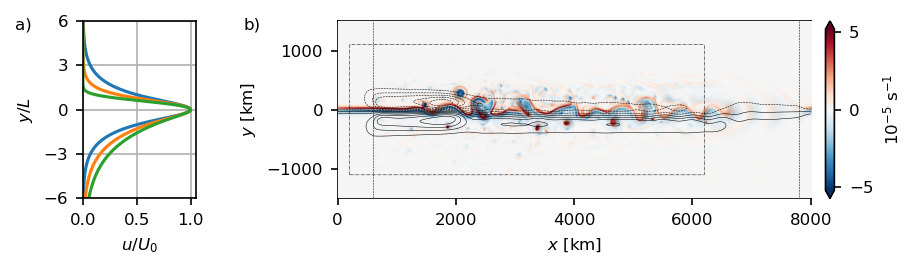

In [212]:
from matplotlib.gridspec import GridSpec

with mpl.rc_context({'font.size': 8}):
    fig = plt.figure(constrained_layout=False, figsize=(6.5, 1.9))
    fig.set_facecolor('w')

    gs = GridSpec(1, 4, figure=fig)

    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1:])
    
    l = .5
    y = np.linspace(-6, 6, 401)

    for δ in (0, .5, 1, ):
        ax1.plot(u1(y, l, δ), y)
    ax1.set_ylim(-6, 6)
    ax1.set_xlim(0, 1.05)
    ax1.set_xticks([0, .5, 1])
    ax1.set_yticks(np.arange(-6,7,3))
    ax1.set_xlabel('$u/U_0$')
    ax1.set_ylabel('$y/L$')
    ax1.grid()

    ves = 2e-2
    cmap = mpl.cm.RdBu_r
    xlim = (0, Lx)
    ylim = (-Ly/2, Ly/2)
    vmin = -vms/2
    vmax =  vms/2
    norm = mpl.colors.Normalize(vmin, vmax)

    pc = ax2.pcolormesh(zeta.xh, zeta.yh, zeta, vmin=vmin, vmax=vmax, cmap=cmap)
        # ax.set_title('$\eta_' + str(n) + '$')
    ax2.set_aspect(1)

    intensity = pw.plt.hillshade(35, 50, h, vertical_exageration=ves)
    rgb = pw.plt.blend_shade(cmap(norm(zeta)), intensity, mid_intensity=.75, min_brightness=.3, max_brightness=.9)
    im = ax2.imshow(np.nan_to_num(rgb, nan=.7), origin='lower', extent=xlim + ylim, zorder=3)
    cbar = fig.colorbar(pc, ax=ax2, extend='both', label='$10^{-5}$ s$^{-1}$', pad=0.025)

    vmax_psi = 140

    levels = np.arange(-vmax_psi, vmax_psi+1, 20)

    ax2.contour(psiB.xq, psiB.yq, psiB, levels=levels, colors='k', linewidths=.25, zorder=5)
    ax2.contour(grid.xq, grid.yh, real_ic.Idamp_u, [.01*float(real_ic.Idamp_u.max())], colors='k', linestyles='--', 
                linewidths=.25, zorder=5)
    ax2.contour(grid.xh, grid.yh, real_ic.Kh, [.01*float(real_ic.Kh.max())], colors='k', linestyles='-.',
                linewidths=.25, zorder=5)
    ax2.set_xlabel('$x$ [km]')
    ax2.set_ylabel('$y$ [km]')
    
    pw.plt.sublabel(np.array([ax1]), xoffset=-.4)
    pw.plt.sublabel(np.array([ax2]), labels='b', xoffset=0)
fig.tight_layout()
fig.savefig(os.path.join(expdir,'proposal_jet.png'), bbox_inches='tight', dpi=300)

In [15]:
def plot_frame(zeta, h, time, vms, ves, cmap, Lx, Ly):
    fig, ax = plt.subplots(figsize=(9, 3))
    fig.set_facecolor('w')

    xlim = (0, Lx)
    ylim = (-Ly/2, Ly/2)
    vmin = -vms/2
    vmax =  vms/2
    norm = mpl.colors.Normalize(vmin, vmax)

    pc = ax.pcolormesh(zeta.xh, zeta.yh, zeta, vmin=vmin, vmax=vmax, cmap=cmap)
        # ax.set_title('$\eta_' + str(n) + '$')
    ax.set_aspect(1)

    intensity = pw.plt.hillshade(35, 50, h, vertical_exageration=ves)
    rgb = pw.plt.blend_shade(cmap(norm(zeta)), intensity, mid_intensity=.75, min_brightness=.3, max_brightness=.9)
    im = ax.imshow(np.nan_to_num(rgb, nan=.7), origin='lower', extent=xlim + ylim, zorder=3)
    cbar = fig.colorbar(pc, ax=ax, extend='both', label='$10^{-5}$ s$^{-1}$', pad=0.025)

    ax.set_title('$t = {:3.0f}$ days'.format(float(time)))
    fig.tight_layout()

    return fig

In [219]:
real_ic.u.max()

<xarray.DataArray 'u' ()>
array(2.0175539)

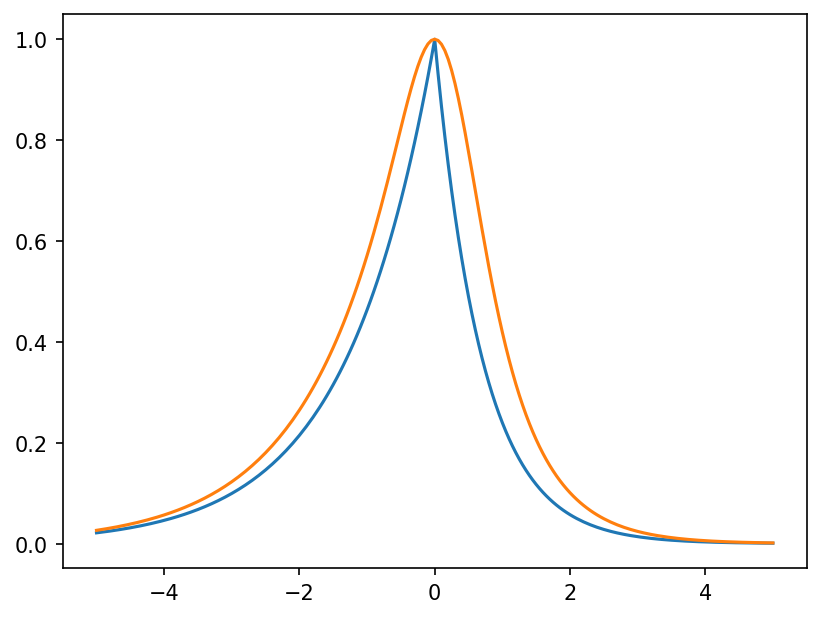

In [226]:
Ω = 7.29e-5
f0 = 2*Ω*sind(35)
δ = 0.3
U = 2
l = .5

y = np.linspace(-5, 5, 201)

us = u1(y, l, δ)
u = u1(y, 0, δ)

plt.plot(y, u)
plt.plot(y, us)

# Close everything

In [109]:
prog.close()
grid.close()
stats.close()
ic.close()
real_ic.close()
mom.close()

try:
    snap.close()
except:
    pass

In [26]:
try:
    client.close()
    cluster.close()
except:
    pass

shutil.rmtree(dask_worker_dir)